In [1]:
%matplotlib inline
import os
import yt
yt.mylog.setLevel("WARNING")
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'stixgeneral'
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt

In [2]:
from yt.fields.derived_field import ValidateSpatial
from yt.funcs import just_one

@yt.derived_field('xray_cooling_time', sampling_type='cell', units='Myr')
def _xray_cooling_time(field, data):
    xray_emis = ('gas', 'xray_emissivity_0.1_100_keV')
    if xray_emis not in data.ds.derived_field_list:
        xray_fields = yt.add_xray_emissivity_field(data.ds, 0.1, 100, table_type='apec', metallicity=0.5)
    gamma = 5./3.
    thermal_energy = 1./(gamma-1)*data['pressure']
    return thermal_energy/data[xray_emis]

@yt.derived_field('total_heating_rate_density', sampling_type='cell', units='erg/s/cm**3')
def _total_heating_rate_density(field, data):
    xray_emis = ('gas', 'xray_emissivity_0.1_100_keV')
    if xray_emis not in data.ds.derived_field_list:
        xray_fields = yt.add_xray_emissivity_field(data.ds, 0.1, 100, table_type='apec', metallicity=0.5)
    return - data['spitzer_heat_flux_divergence'] - data[xray_emis]

@yt.derived_field('spitzer_conduction_coefficient', sampling_type='cell', units='cm**2/s')
def _spitzer_conduction_coefficient(field, data):
    T1 = data['temperature'].to_equivalent('keV', 'thermal')/10/yt.units.keV
    n = data['H_nuclei_density']/1E-3/yt.units.cm**(-3)
    return 4E32*T1**2.5/n*yt.units.cm**2*yt.units.s**(-1)

def _spitzer_heat_flux(ax):
    def func(field, data):
        return -data['spitzer_conduction_coefficient']*yt.physical_constants.kb*data['H_nuclei_density']*data['temperature_gradient_%s' % ax]
    return func

for ax in 'xyz':
    f = _spitzer_heat_flux(ax)
    yt.add_field('spitzer_heat_flux_%s' % ax, function=f, sampling_type='cell', units='erg/s/cm**2')
    

basename = 'spitzer_heat_flux'
xn = basename + '_x'
yn = basename + '_y'
zn = basename + '_z'

sl_left = slice(None, -2, None)
sl_right = slice(2, None, None)

div_fac = 2


def _divergence(field, data):
    ds = div_fac * just_one(data["index", "dx"])
    f  = data[xn][sl_right,1:-1,1:-1]/ds
    f -= data[xn][sl_left ,1:-1,1:-1]/ds
    ds = div_fac * just_one(data["index", "dy"])
    f += data[yn][1:-1,sl_right,1:-1]/ds
    f -= data[yn][1:-1,sl_left ,1:-1]/ds
    ds = div_fac * just_one(data["index", "dz"])
    f += data[zn][1:-1,1:-1,sl_right]/ds
    f -= data[zn][1:-1,1:-1,sl_left ]/ds
    new_field = data.ds.arr(np.zeros(data[xn].shape, dtype=np.float64),
                            f.units)        
    new_field[1:-1,1:-1,1:-1] = f
    return new_field


yt.add_field(('gas', "%s_divergence" % basename), sampling_type="cell", 
                   function=_divergence,
                   units='erg/s/cm**3',
                   validators=[ValidateSpatial(2)])

def _spitzer_heating_rate(field, data):
    return -data[('gas', 'spitzer_heat_flux_divergence')]*data[('gas', 'cell_volume')]

yt.add_field(('gas', 'spitzer_heating_rate'), sampling_type="cell", 
                   function=_spitzer_heating_rate,
                   units='erg/s')

def _total_heating_rate(field, data):
    return -data[('gas', 'total_heating_rate_density')]*data[('gas', 'cell_volume')]

yt.add_field(('gas', 'total_heating_rate'), sampling_type="cell", 
                   function=_total_heating_rate,
                   units='erg/s')

def _total_cooling_time(field, data):
    gamma = 5./3.
    thermal_energy = 1./(gamma-1)*data['pressure']
    return thermal_energy/(-data['total_heating_rate'])

yt.add_field(('gas', 'total_cooling_time'), sampling_type="cell", 
                   function=_total_cooling_time,
                   units='Myr')

In [3]:
ds = yt.load('/home/ychen/data/0only_0529_h1//data/MHD_Jet_hdf5_plt_cnt_0000')
sp1 = ds.sphere([0,0,0], (180, 'kpc'))
sp2 = ds.sphere([0,0,0], (2, 'kpc'))
sp = sp1 - sp2

ds.derived_field_list

[('all', 'mesh_id'),
 ('all', 'particle_blk'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_den0'),
 ('all', 'particle_dens'),
 ('all', 'particle_gamc'),
 ('all', 'particle_index'),
 ('all', 'particle_jet'),
 ('all', 'particle_magx'),
 ('all', 'particle_magy'),
 ('all', 'particle_magz'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_posx'),
 ('all', 


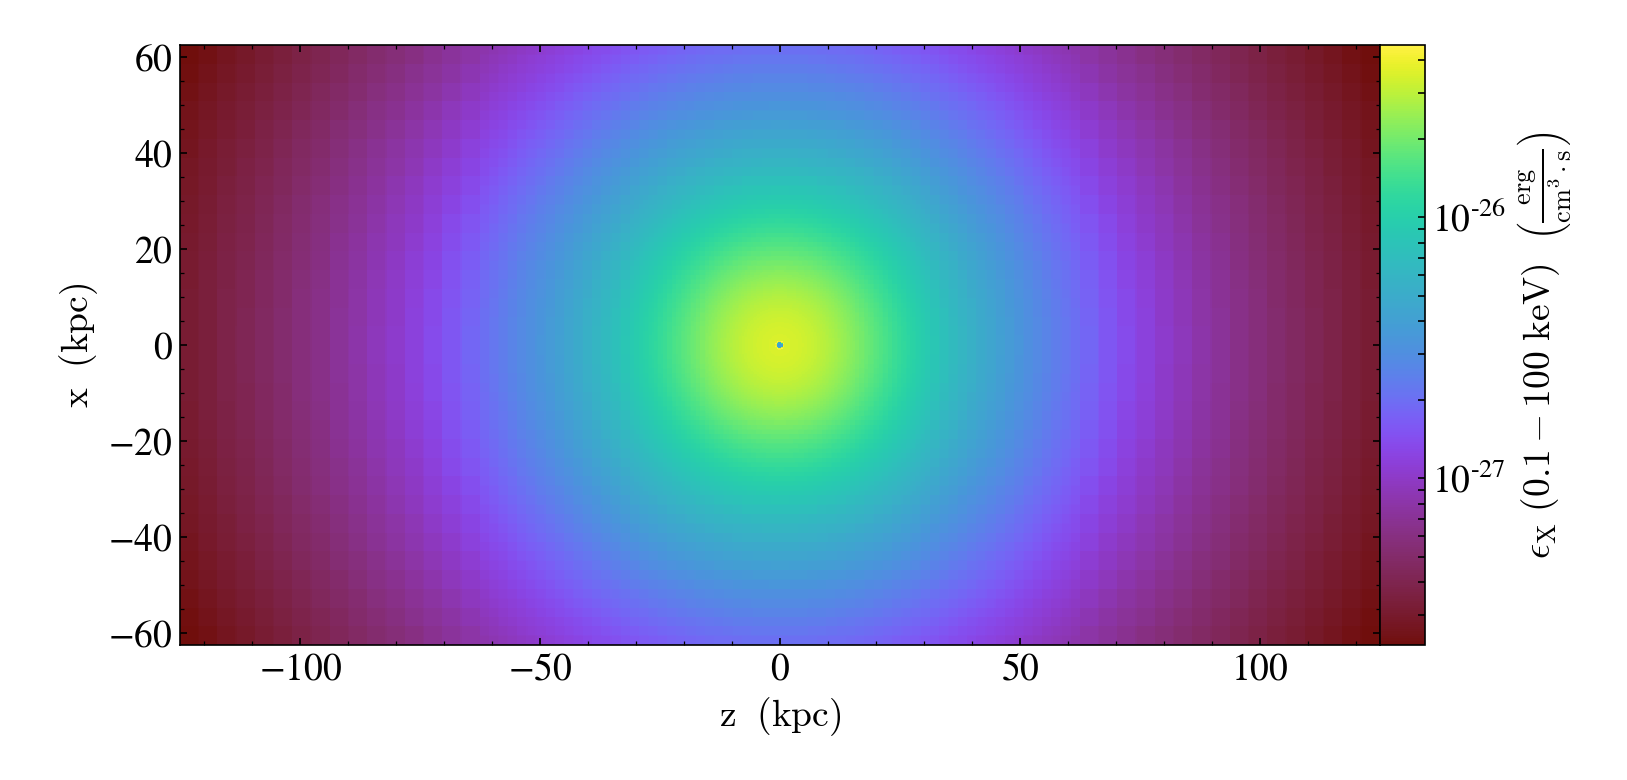

In [4]:
plot = yt.SlicePlot(ds, 'y', 'xray_emissivity_0.1_100_keV')
plot.zoom(4)
plot.show()



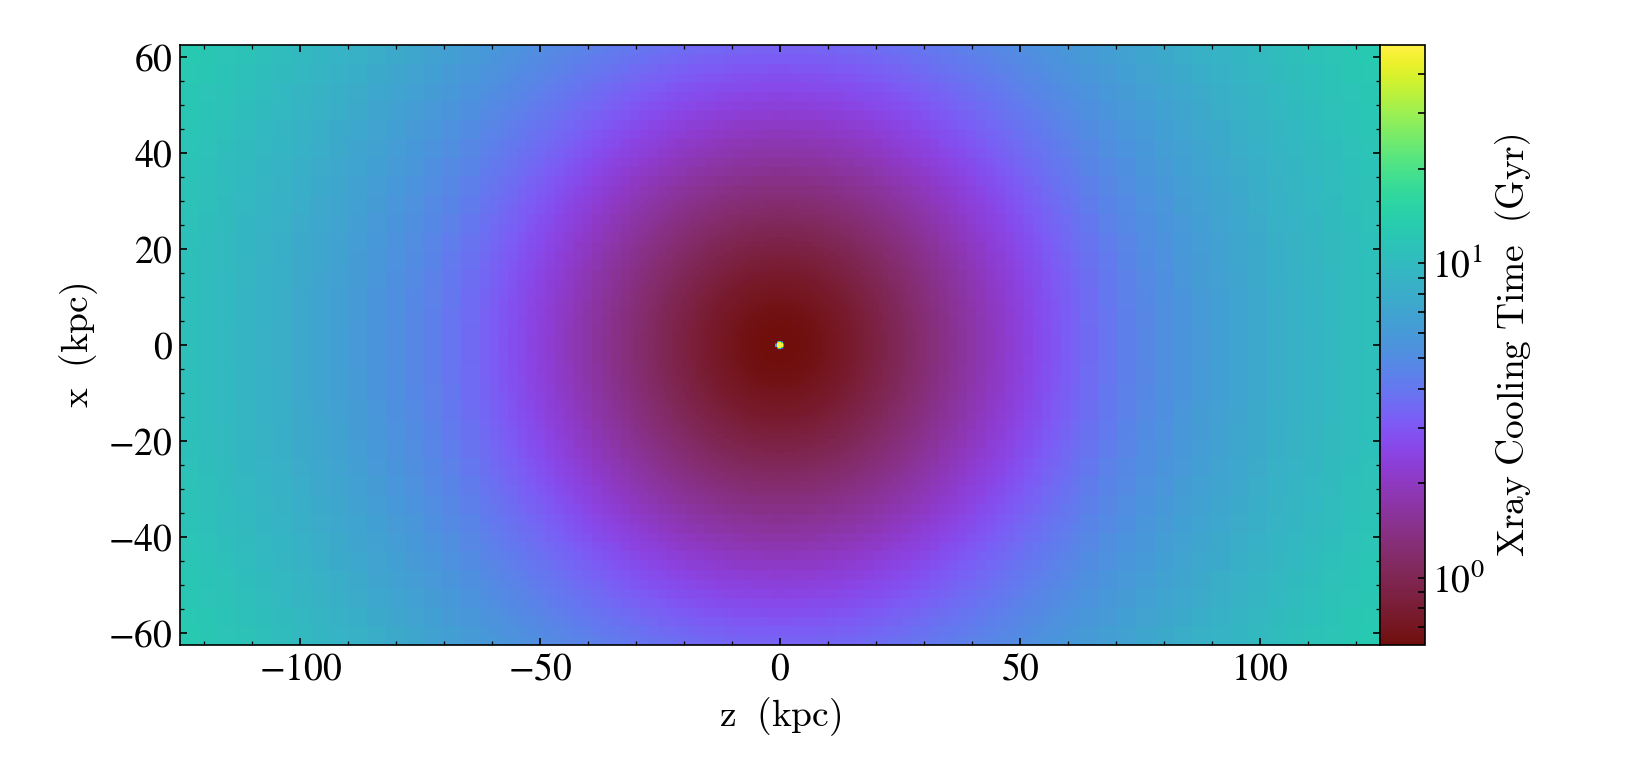

In [5]:
plot = yt.SlicePlot(ds, 'y', 'xray_cooling_time', )
plot.set_unit('xray_cooling_time', 'Gyr')
plot.zoom(4)
plot.show()


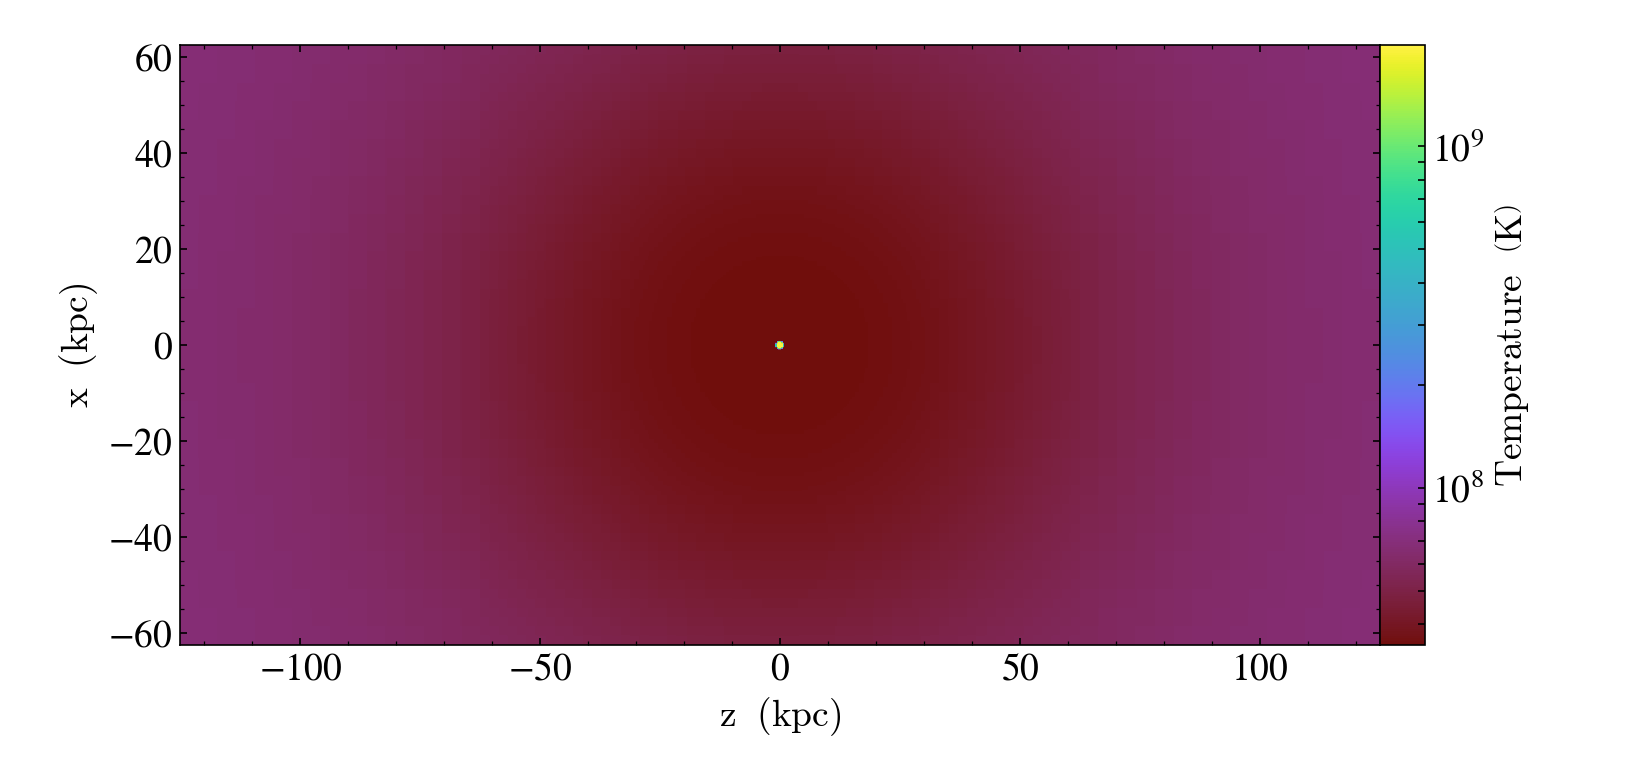

In [6]:
plot = yt.SlicePlot(ds, 'y', 'temperature')
plot.zoom(4)
plot.show()


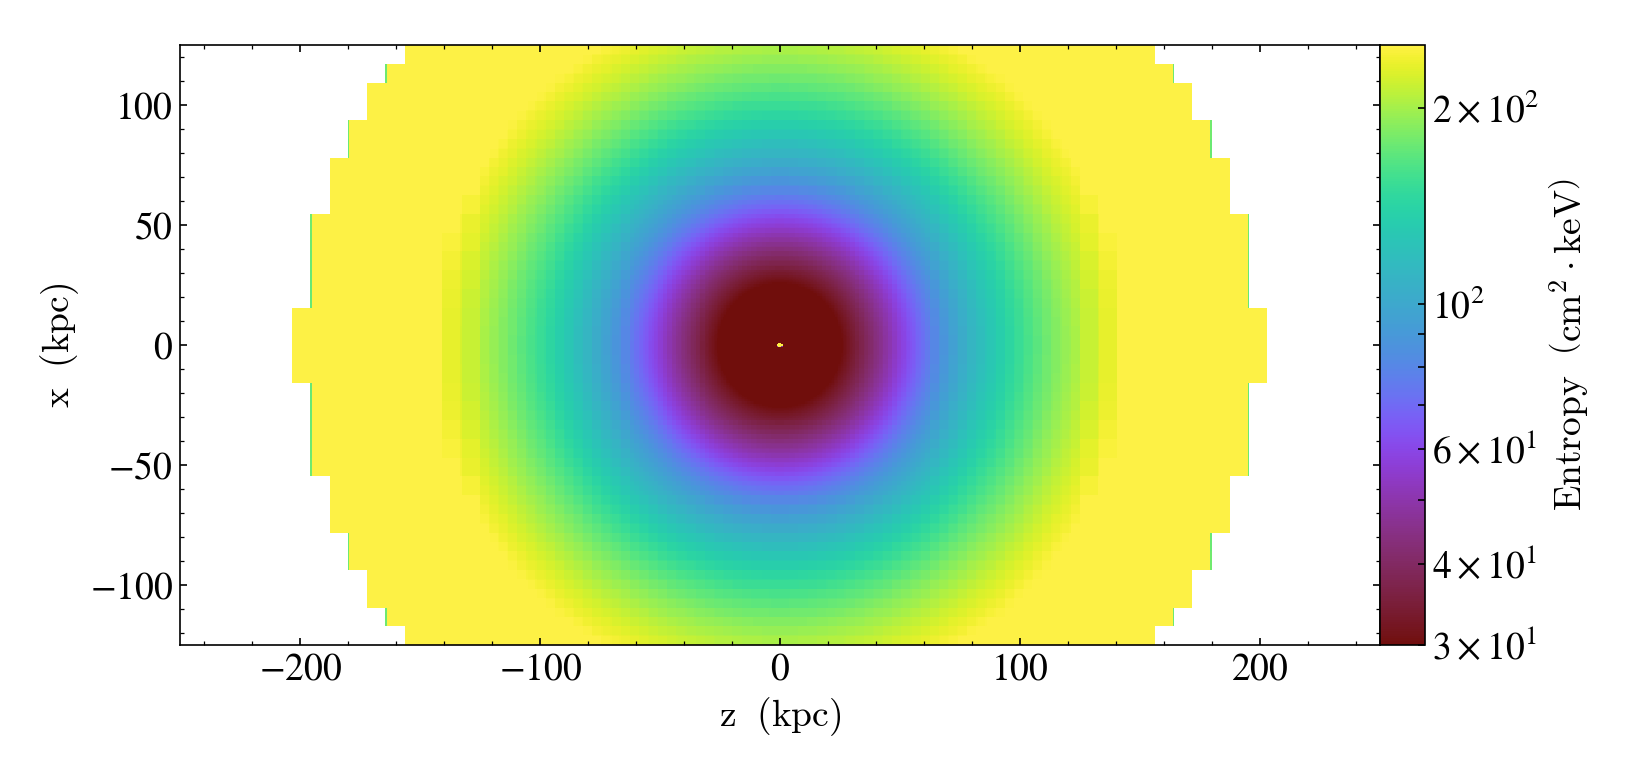

In [7]:
plot = yt.SlicePlot(ds, 'y', 'entropy', data_source=sp)
plot.set_zlim('entropy', 30, 250)
plot.zoom(2)
plot.show()


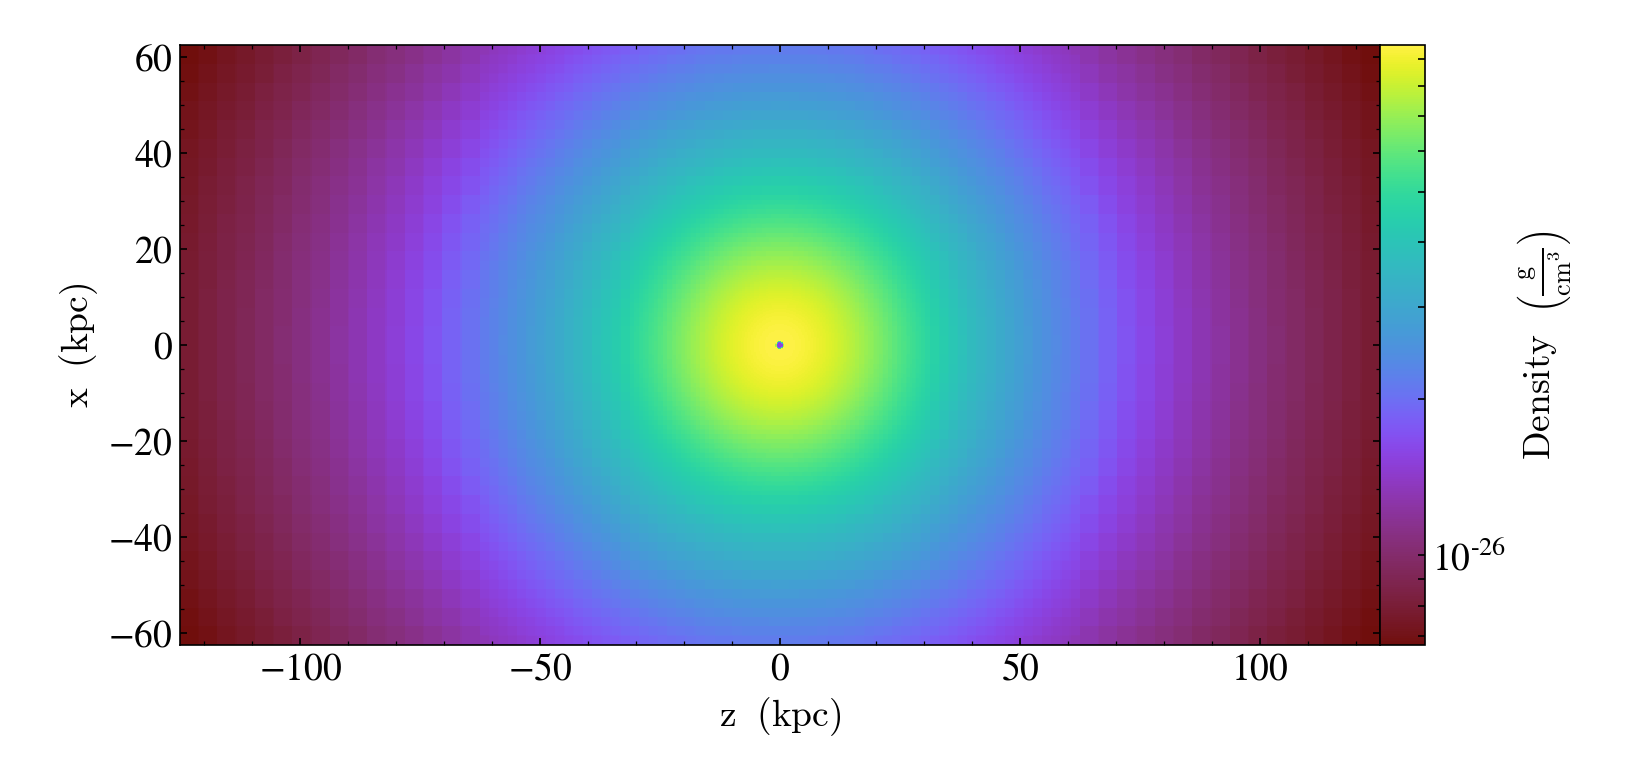

In [8]:
plot = yt.SlicePlot(ds, 'y', 'density')
plot.zoom(4)
plot.show()

In [9]:
prof = yt.Profile2D(sp, 'spherical_radius', 100, 0.1, 100, True, 'entropy', 100, 10, 300, True)


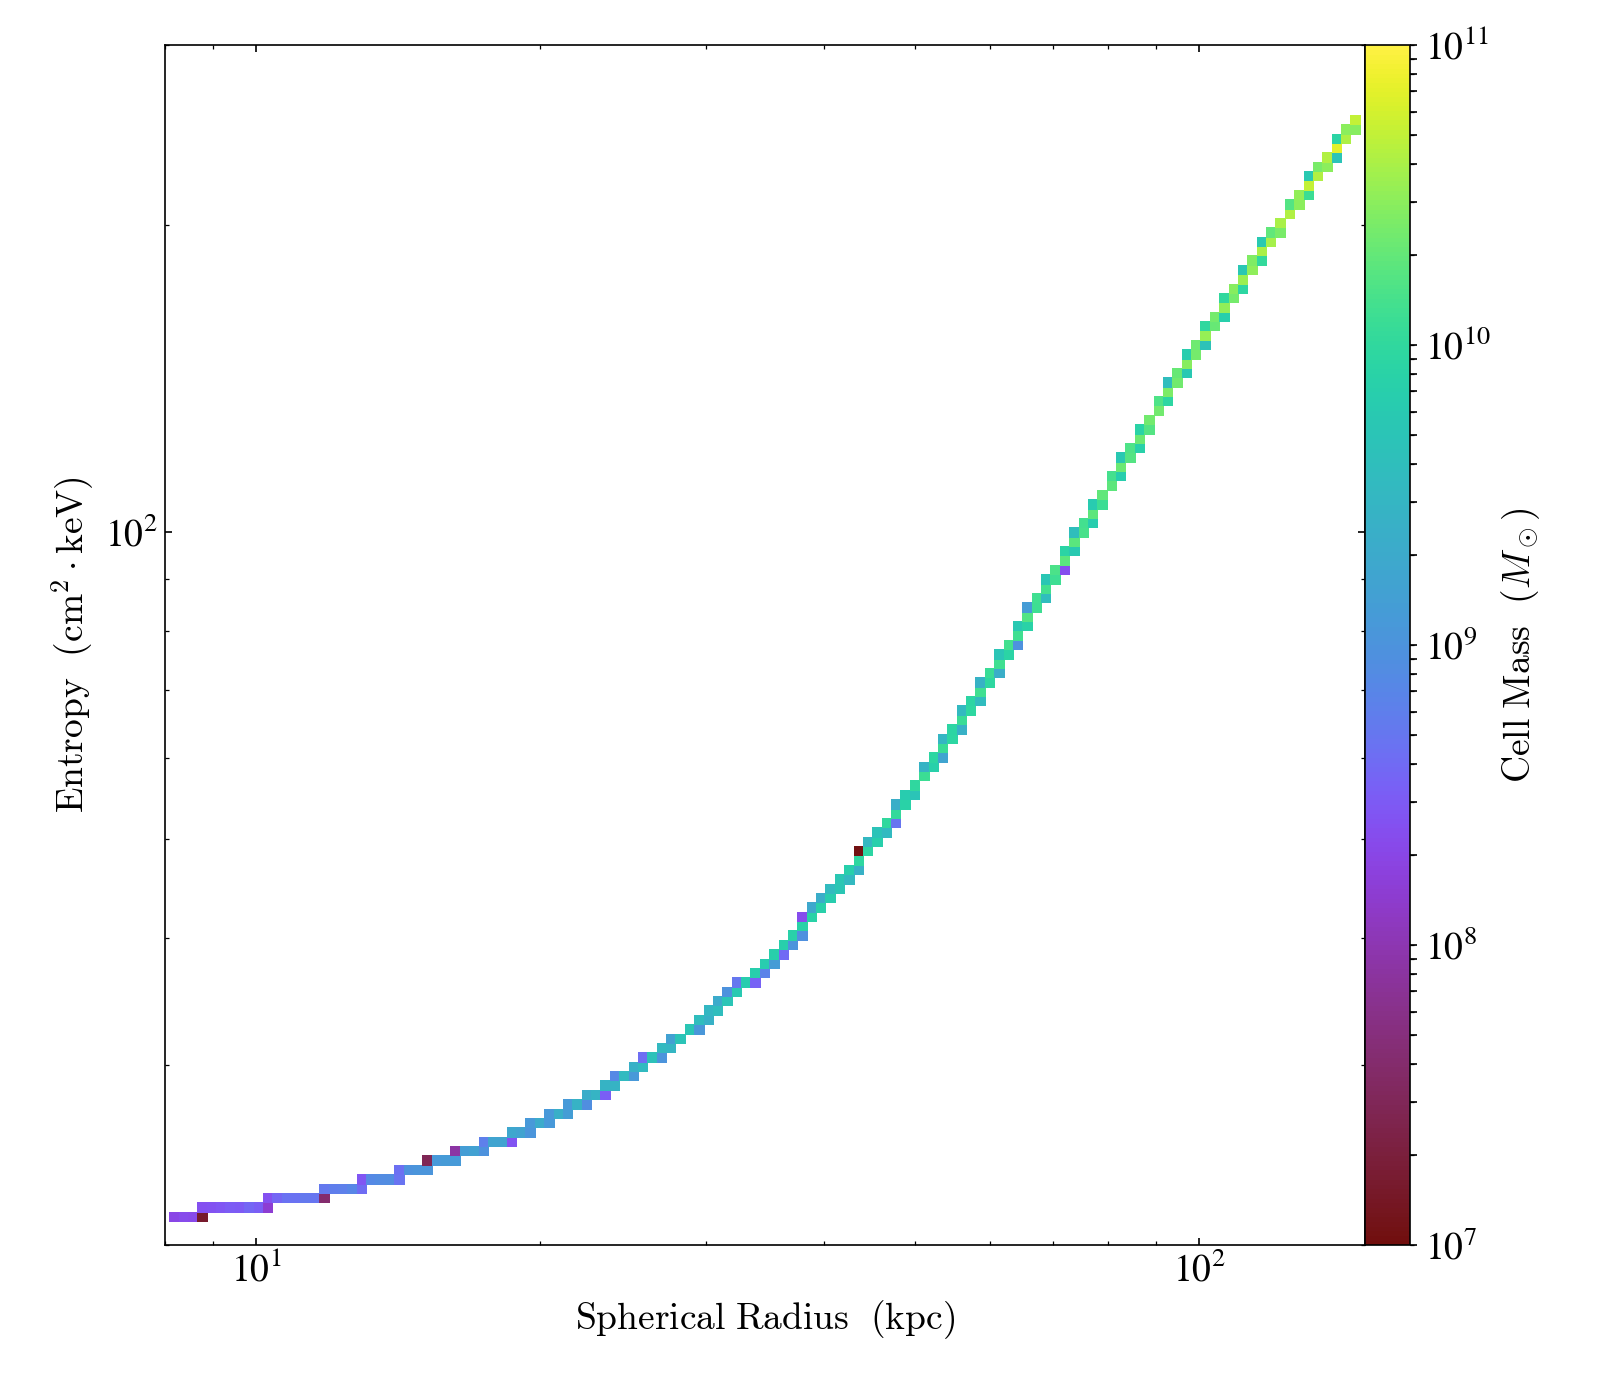

['MHD_Jet_hdf5_plt_cnt_0000_2d-Profile_spherical_radius_entropy_cell_mass.png']

In [10]:
pp = yt.PhasePlot(sp, 'spherical_radius', 'entropy', 'cell_mass', weight_field=None)
pp.set_unit('spherical_radius', 'kpc')
pp.set_unit('cell_mass', 'Msun')
pp.set_xlim(8, 150)
pp.set_ylim(20, 300)
pp.set_zlim('cell_mass', 1E7, 1E11)
pp.show()
pp.save()

In [11]:
sp

YTSphere (MHD_Jet_hdf5_plt_cnt_0000): , center=[ 0.  0.  0.] cm, radius=6.171355161924649e+23 cm


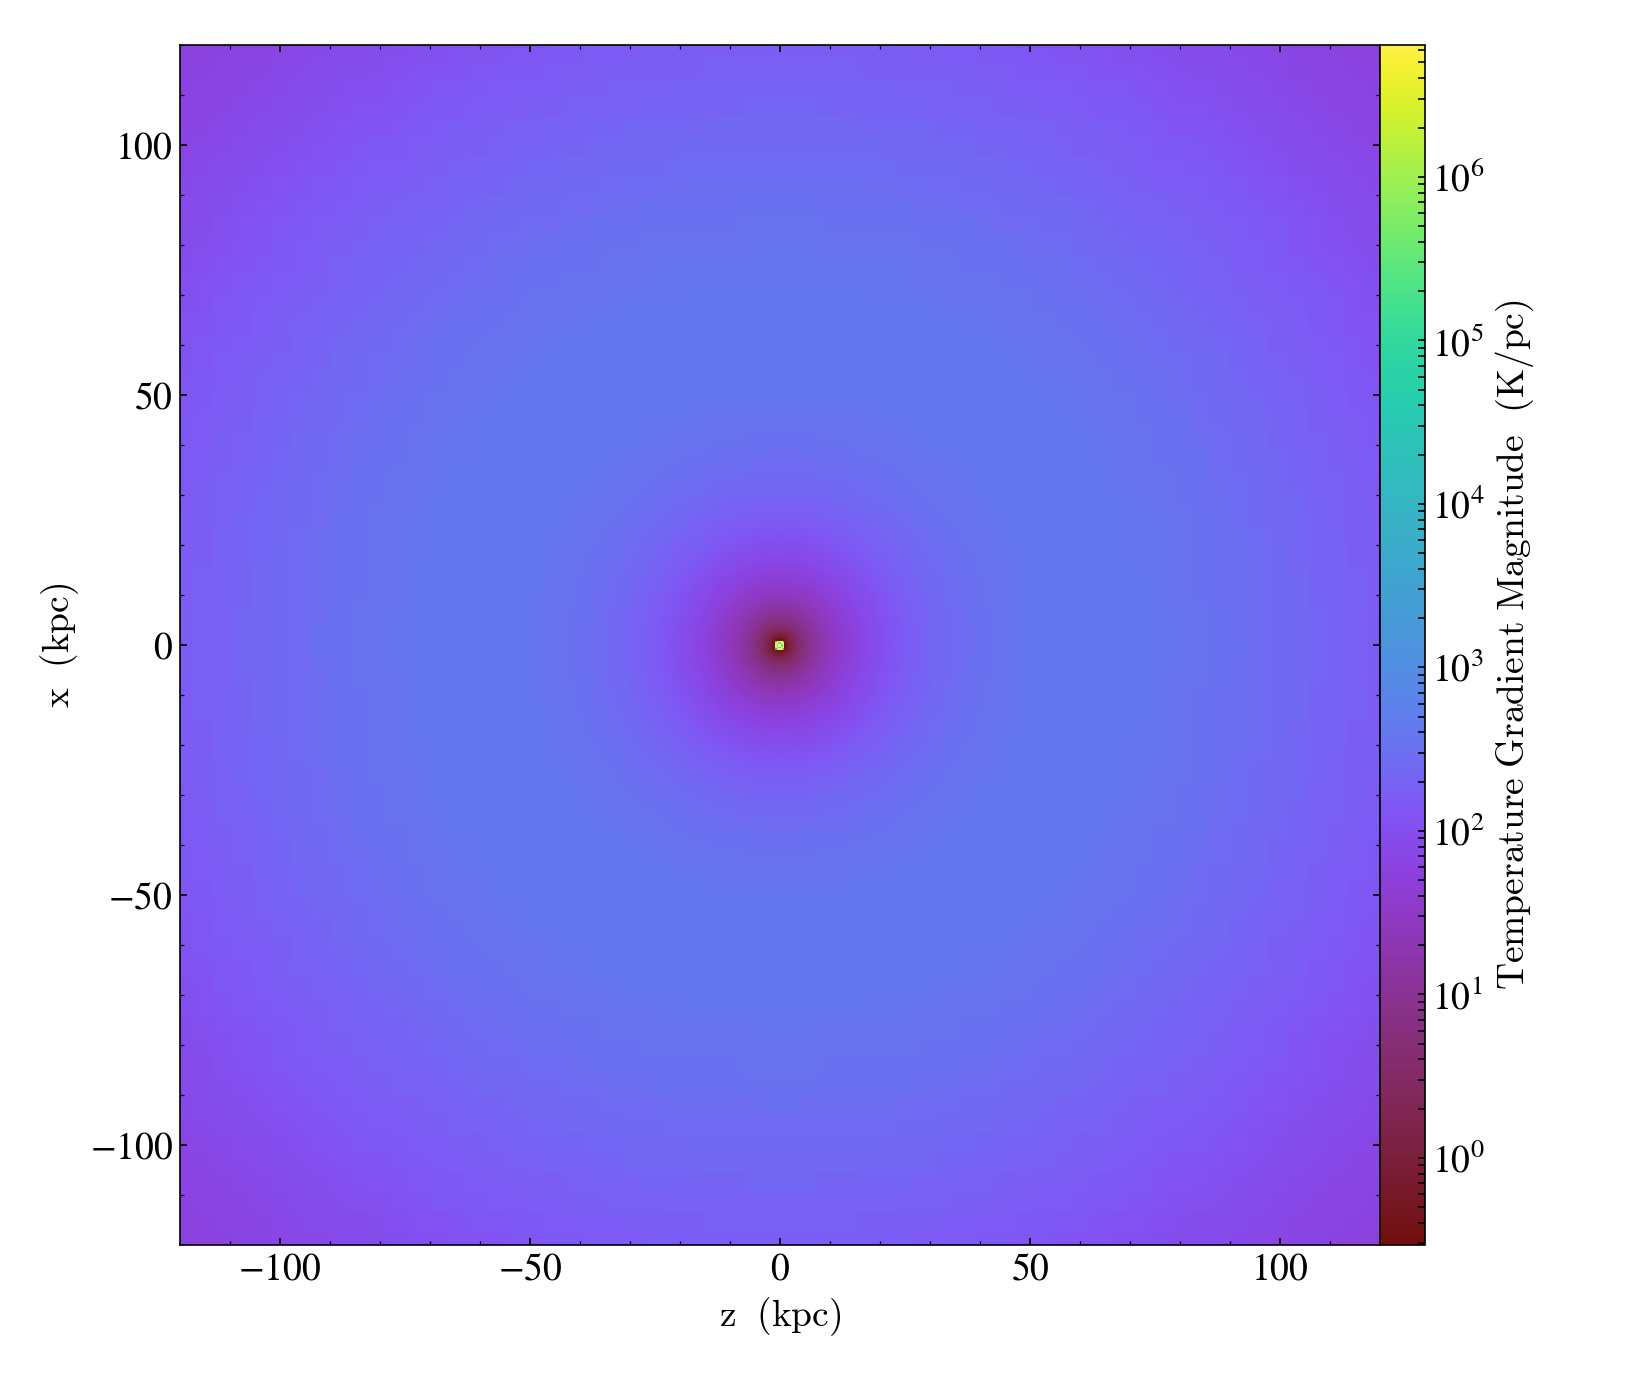

In [13]:
plot = yt.SlicePlot(ds, 'y', 'temperature_gradient_magnitude', data_source=sp, width=(240, 'kpc'))
plot.set_unit('temperature_gradient_magnitude', 'K/pc')
plot.show()

yt : [WARNING  ] 2018-05-12 14:53:28,660 Plot image for field ('gas', 'temperature_gradient_x') has both positive and negative values. Min = -0.000000, Max = 0.000000.
yt : [WARNING  ] 2018-05-12 14:53:28,665 Switching to symlog colorbar scaling unless linear scaling is specified later



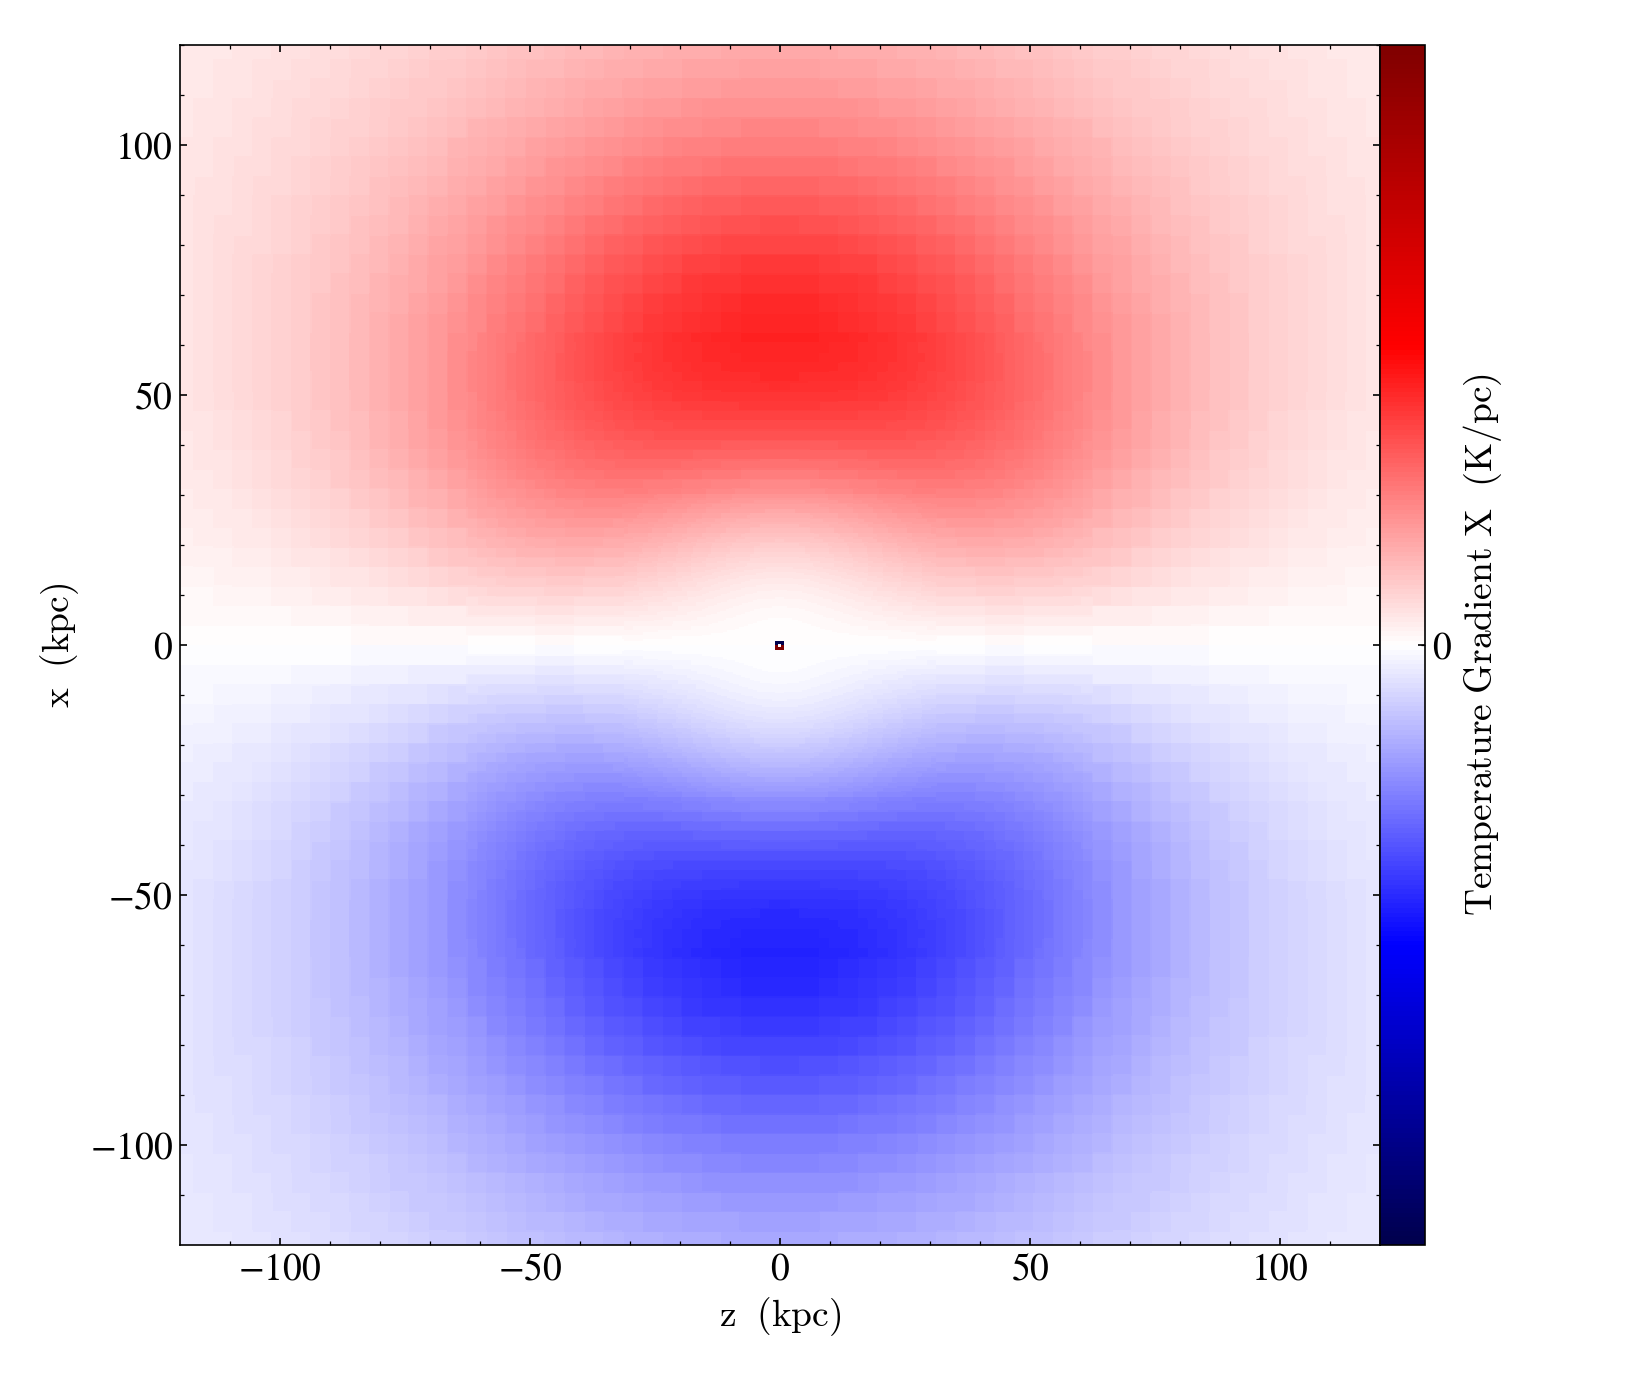

In [14]:
plot = yt.SlicePlot(ds, 'y', 'temperature_gradient_x', data_source=sp, width=(240, 'kpc'))
plot.set_unit('temperature_gradient_x', 'K/pc')
plot.set_cmap('temperature_gradient_x', 'seismic')
plot.set_zlim('temperature_gradient_x', -1E3, 1E3)
plot.show()


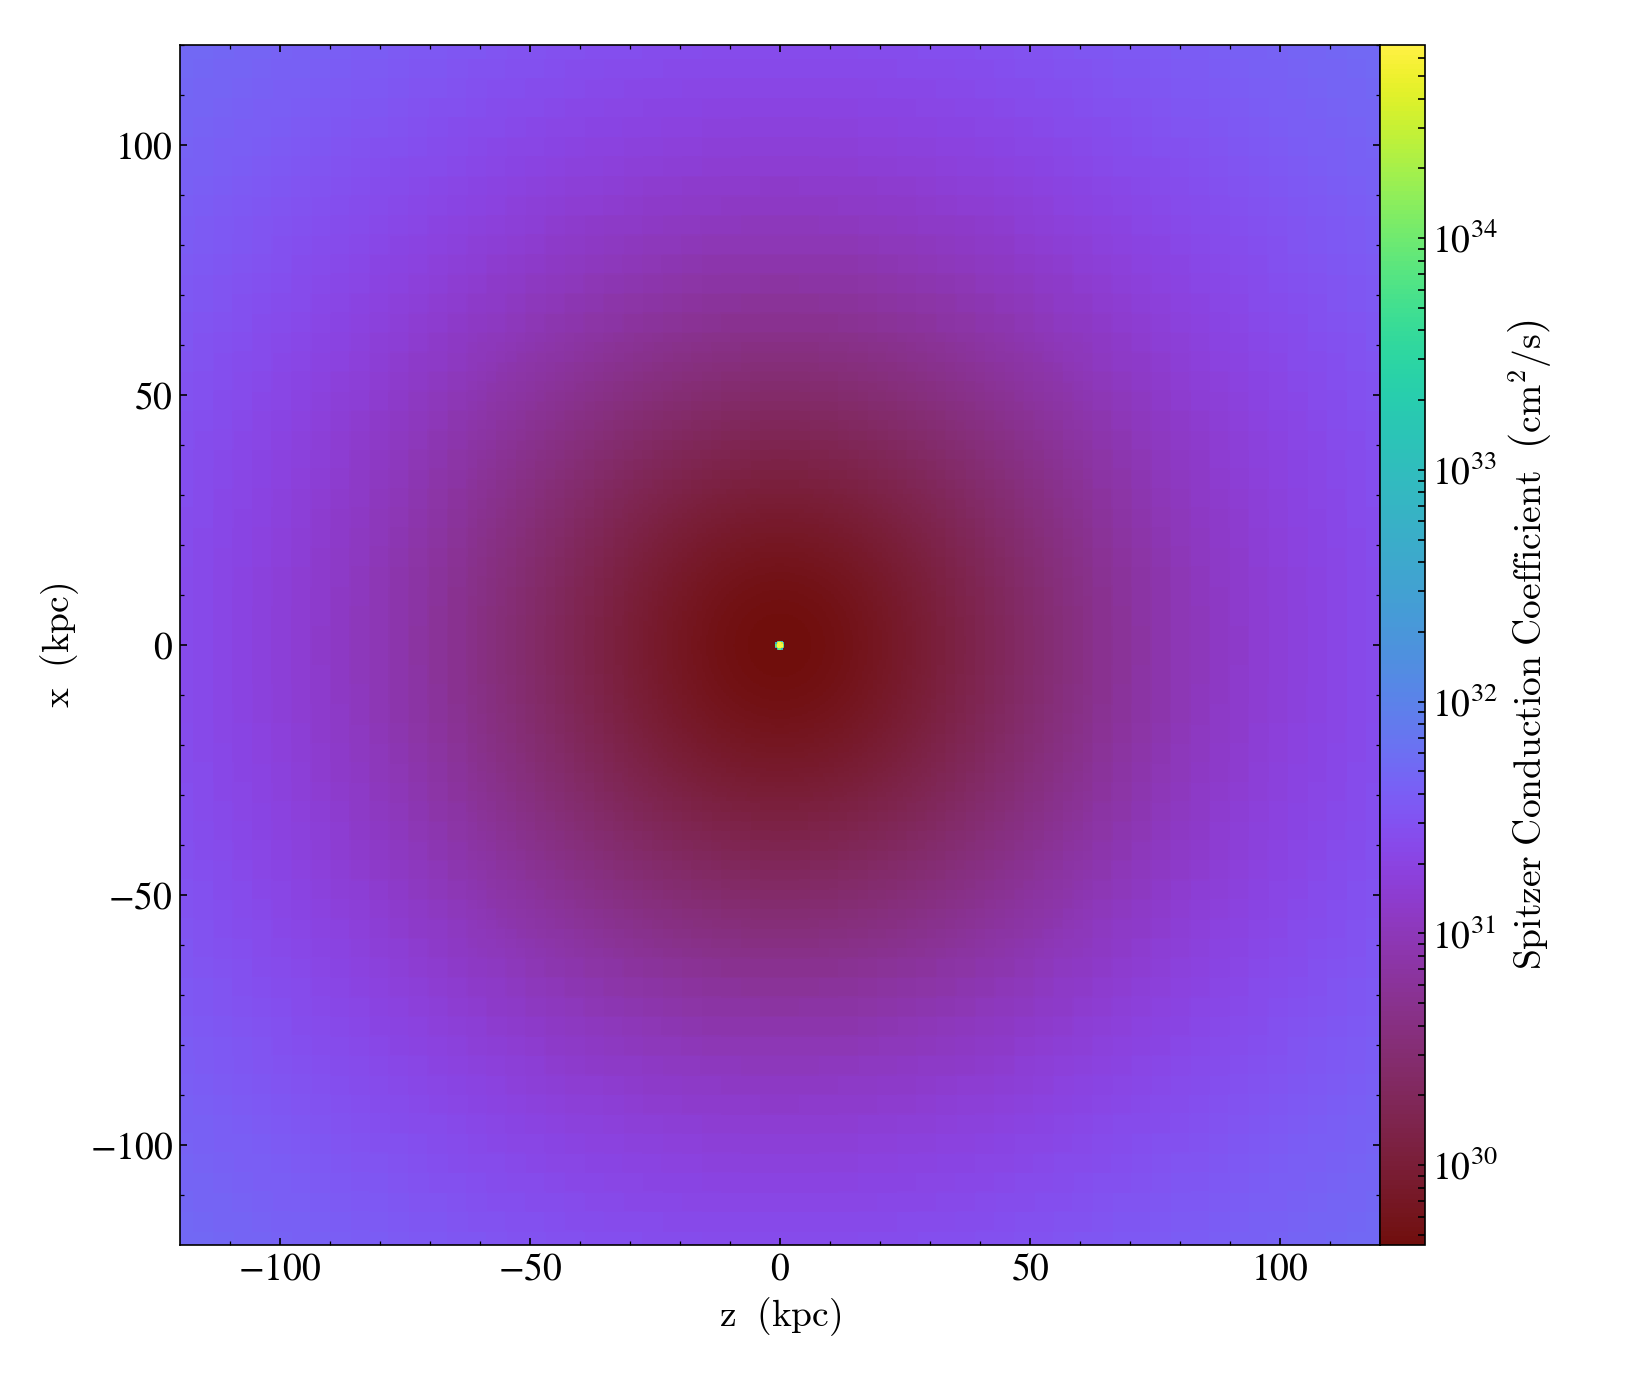

In [15]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_conduction_coefficient', data_source=sp, width=(240, 'kpc'))
plot.show()

yt : [WARNING  ] 2018-05-12 14:54:06,099 Plot image for field ('gas', 'spitzer_heat_flux_x') has both positive and negative values. Min = -35856.868548, Max = 35856.868548.
yt : [WARNING  ] 2018-05-12 14:54:06,103 Switching to symlog colorbar scaling unless linear scaling is specified later



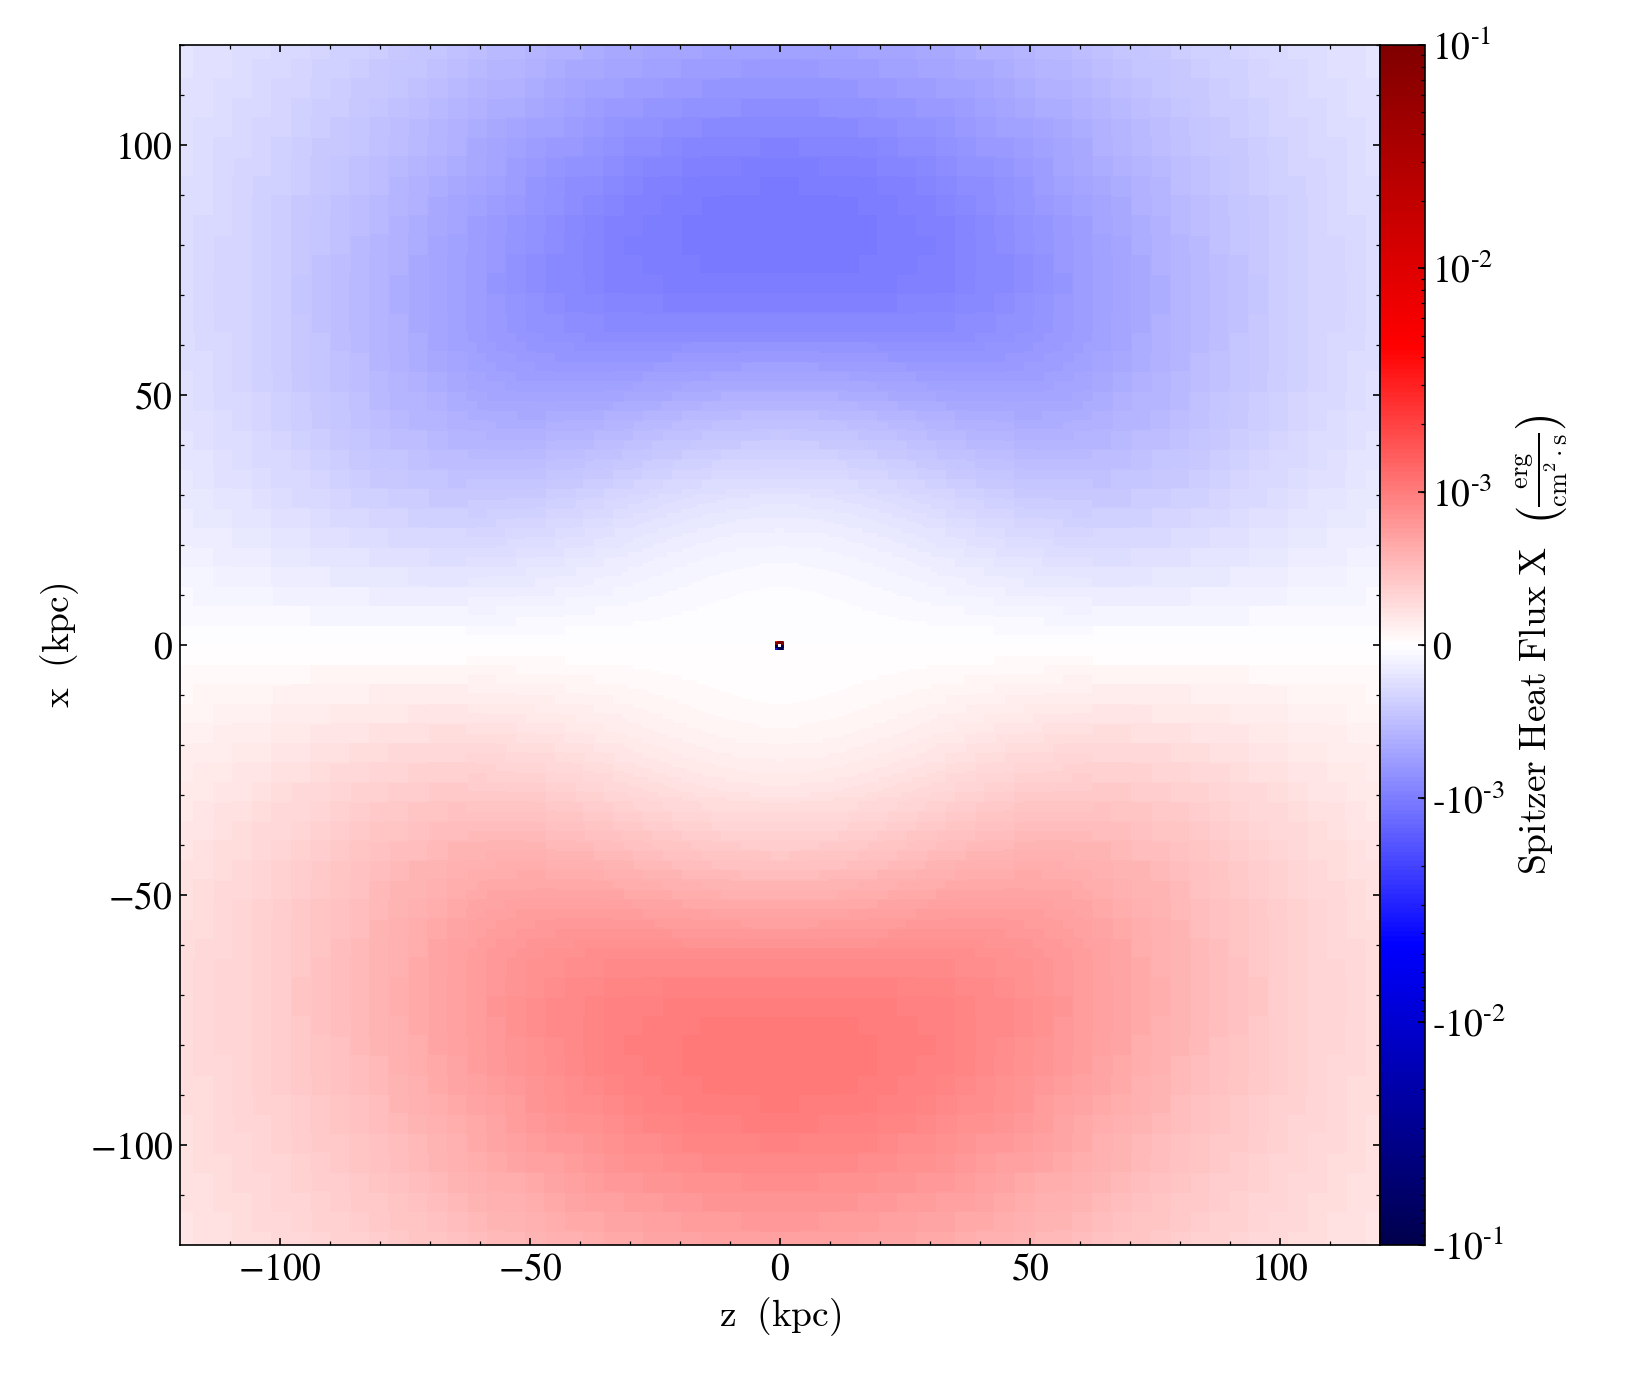

In [16]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_heat_flux_x', data_source=sp, width=(240, 'kpc'))
plot.set_log('spitzer_heat_flux_x' , True, linthresh=1E-3)
plot.set_cmap('spitzer_heat_flux_x', 'seismic')
plot.set_zlim('spitzer_heat_flux_x', -1E-1, 1E-1)
plot.show()

In [40]:
kpc = yt.units.kpc
(kpc**3).in_units('cm**3')

2.937998944585178e+64 cm**3

yt : [WARNING  ] 2018-05-13 16:18:46,263 Plot image for field ('gas', 'spitzer_heat_flux_divergence') has both positive and negative values. Min = -0.000000, Max = 0.000000.
yt : [WARNING  ] 2018-05-13 16:18:46,268 Switching to symlog colorbar scaling unless linear scaling is specified later



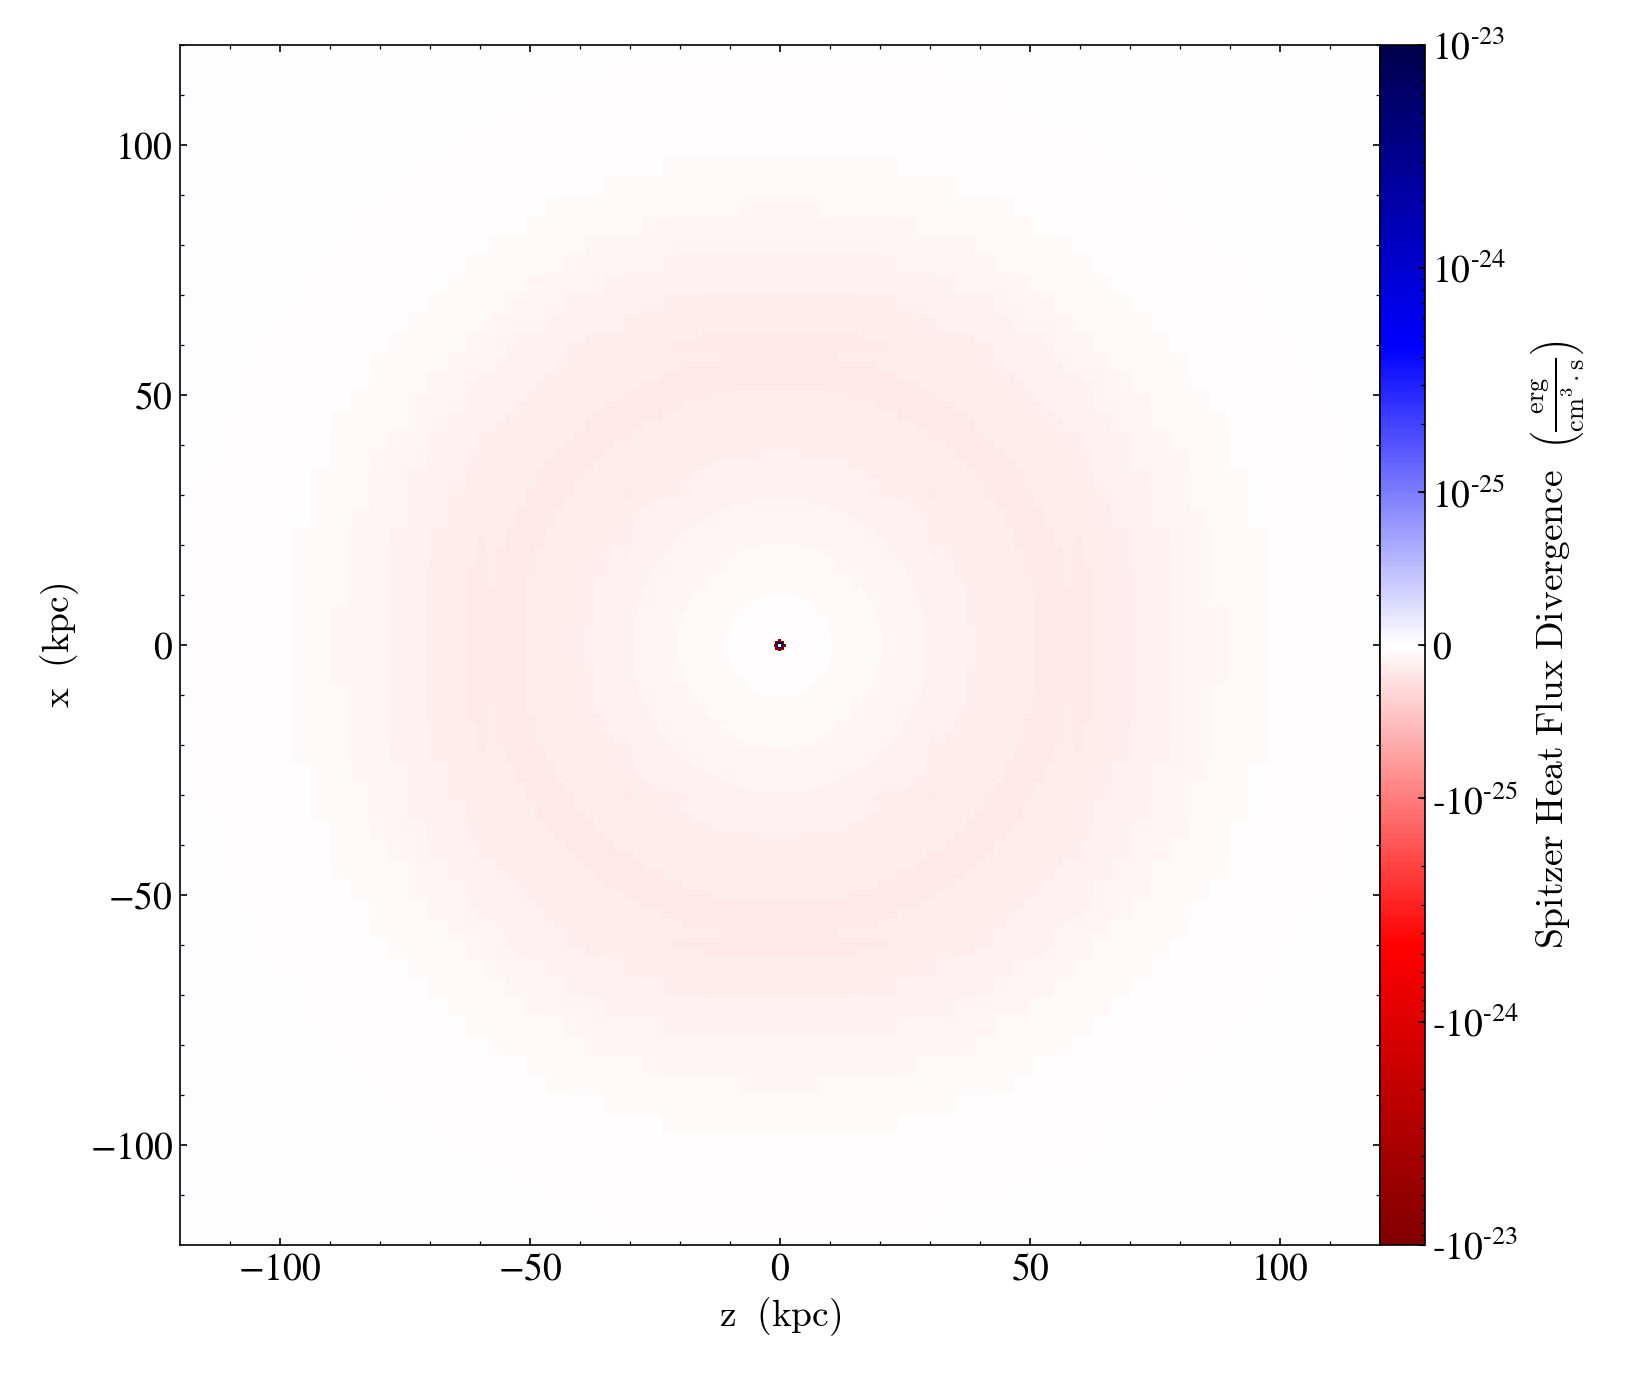

In [4]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_heat_flux_divergence', data_source=sp, width=(240, 'kpc'))

plot.set_log('spitzer_heat_flux_divergence' , True, linthresh=1E-25)
plot.set_cmap('spitzer_heat_flux_divergence', 'seismic_r')
plot.set_zlim('spitzer_heat_flux_divergence', -1E-23, 1E-23)
plot.show()

yt : [WARNING  ] 2018-05-14 14:07:17,855 Plot image for field ('gas', 'spitzer_heating_rate') has both positive and negative values. Min = -65927446144014389221160449165148554541400064.000000, Max = 38496963564892474039391748162905239600496640.000000.
yt : [WARNING  ] 2018-05-14 14:07:17,859 Switching to symlog colorbar scaling unless linear scaling is specified later



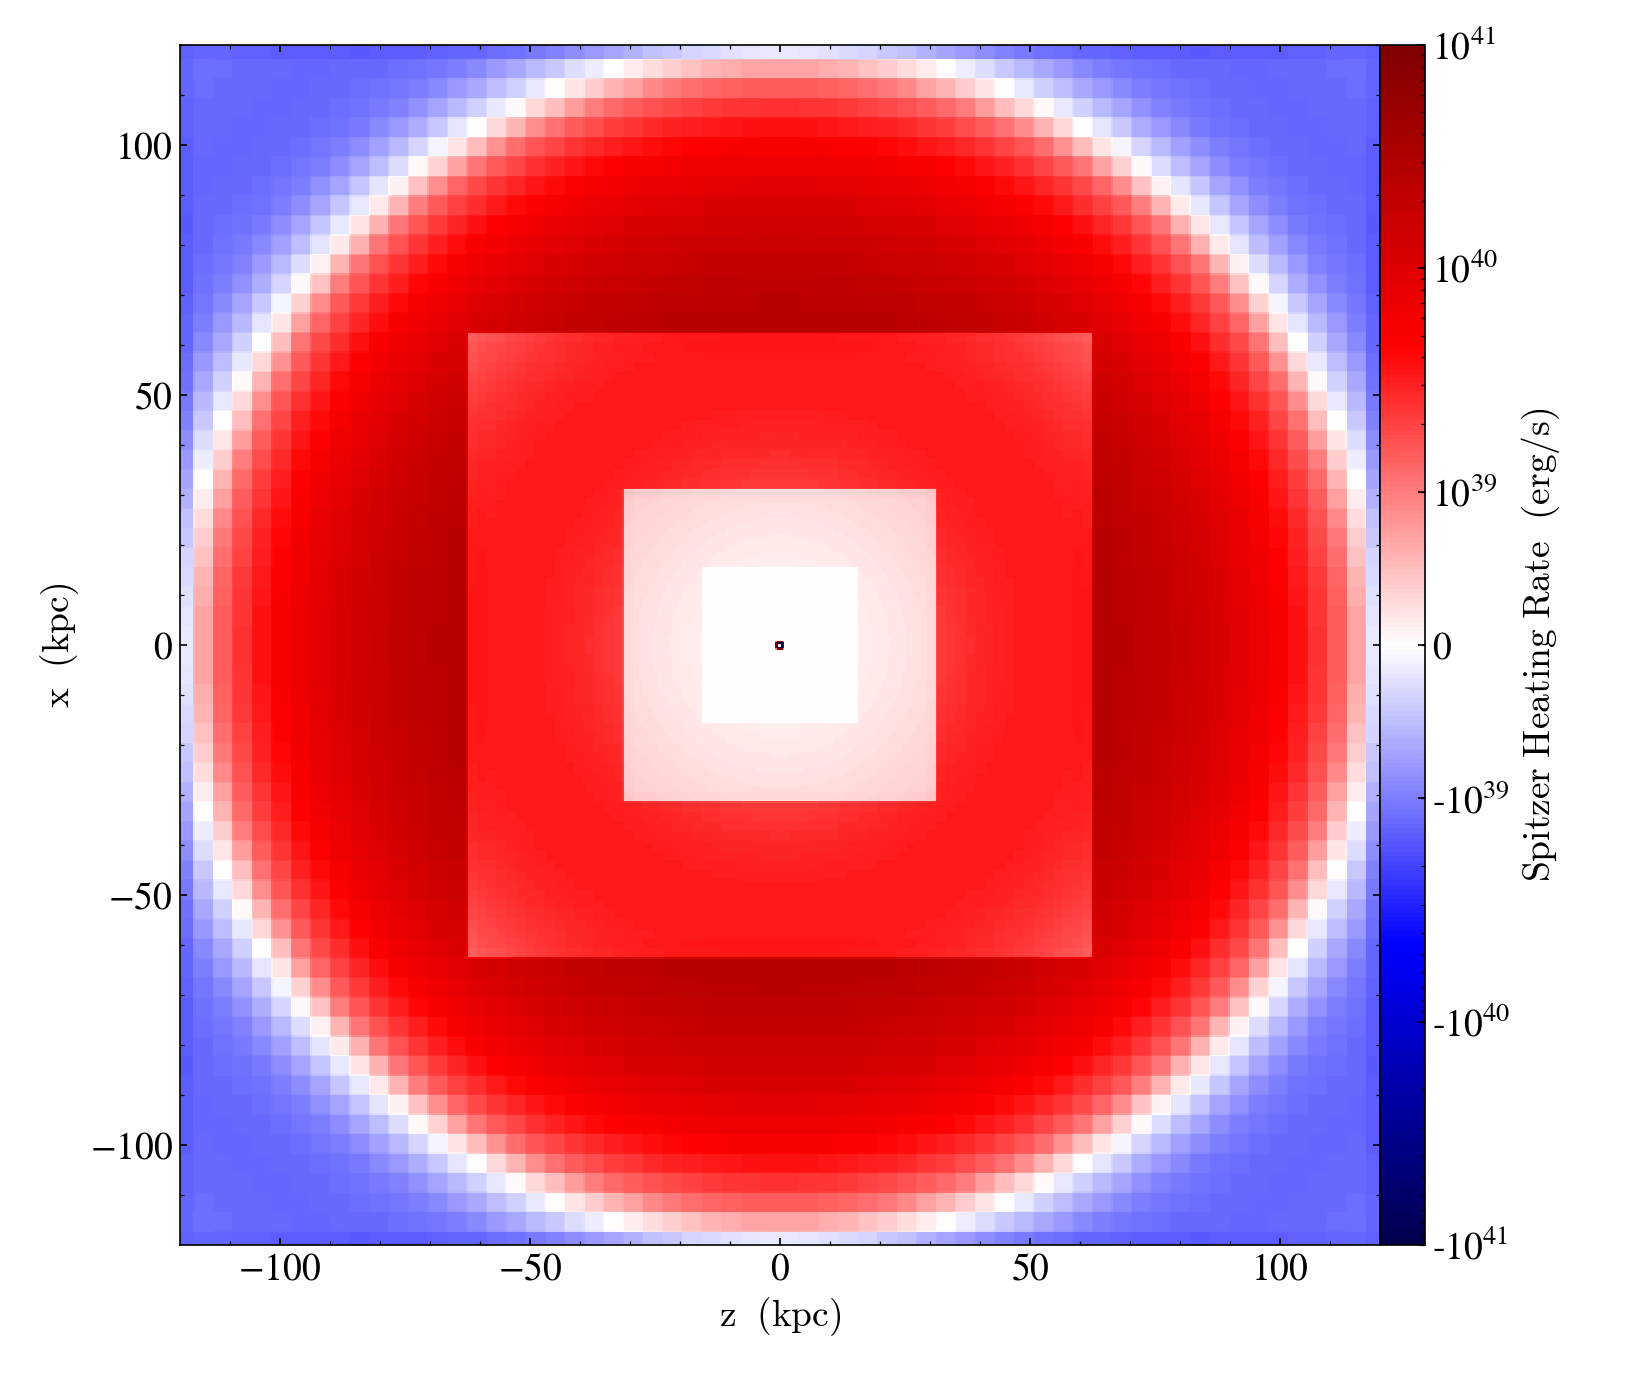

In [39]:
plot = yt.SlicePlot(ds, 'y', 'spitzer_heating_rate', data_source=sp, width=(240, 'kpc'))

plot.set_log('spitzer_heating_rate' , True, linthresh=1E39)
plot.set_cmap('spitzer_heating_rate', 'seismic')
plot.set_zlim('spitzer_heating_rate', -1E41, 1E41)
plot.show()

yt : [WARNING  ] 2018-05-13 16:20:43,420 Plot image for field ('gas', 'total_heating_rate') has both positive and negative values. Min = -0.000000, Max = 0.000000.
yt : [WARNING  ] 2018-05-13 16:20:43,424 Switching to symlog colorbar scaling unless linear scaling is specified later



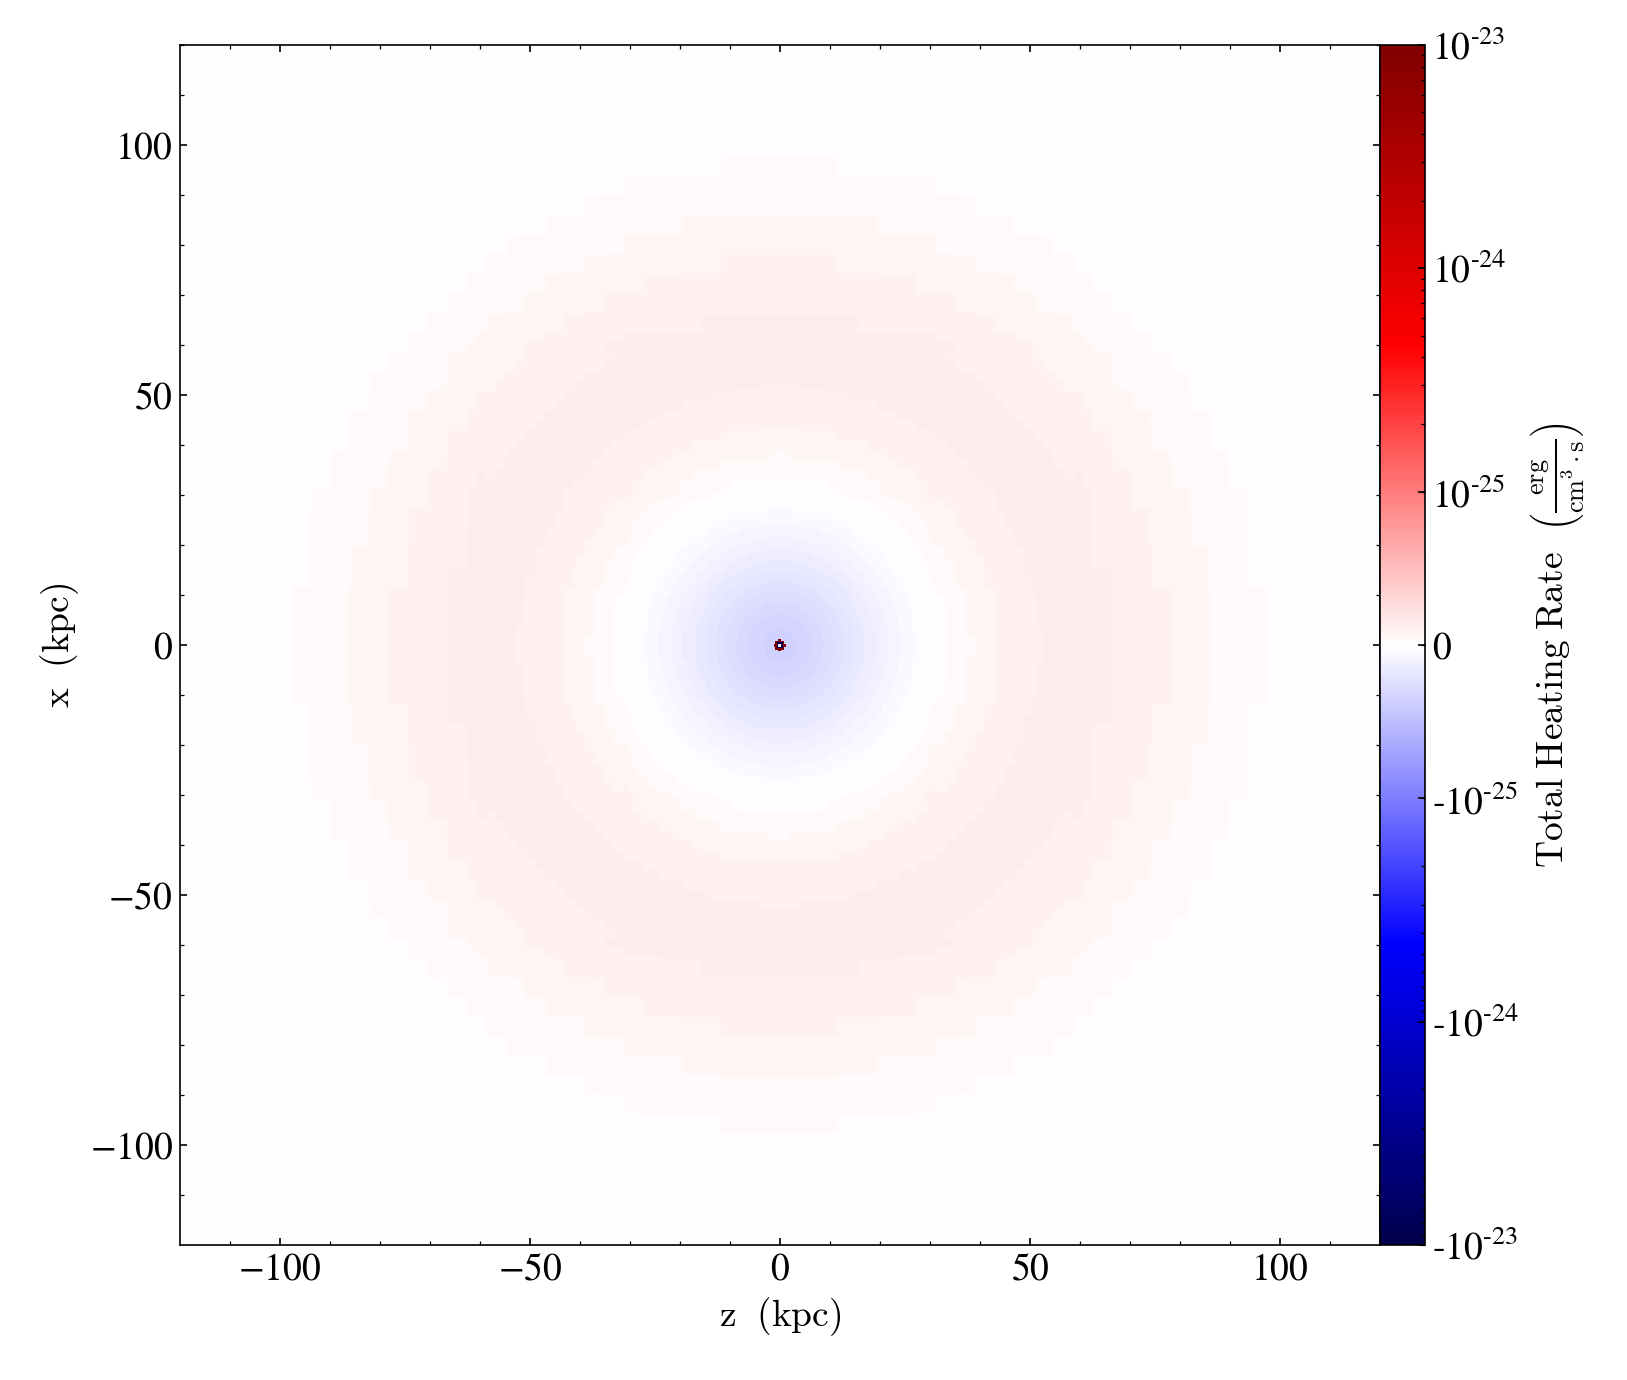

In [6]:
plot = yt.SlicePlot(ds, 'y', 'total_heating_rate', data_source=sp, width=(240, 'kpc'))

plot.set_log('total_heating_rate' , True, linthresh=1E-25)
plot.set_cmap('total_heating_rate', 'seismic')
plot.set_zlim('total_heating_rate', -1E-23, 1E-23)
plot.show()

In [44]:
extrema = {'entropy': (20, 324)}
logs = {'entropy': True}
fields = ['spitzer_heating_rate', 'xray_luminosity_0.1_100_keV', 'cell_mass']
prof_entropy = yt.create_profile(sp, 'entropy', fields, weight_field=None, 
                         extrema=extrema, logs=logs)

(20, 324)

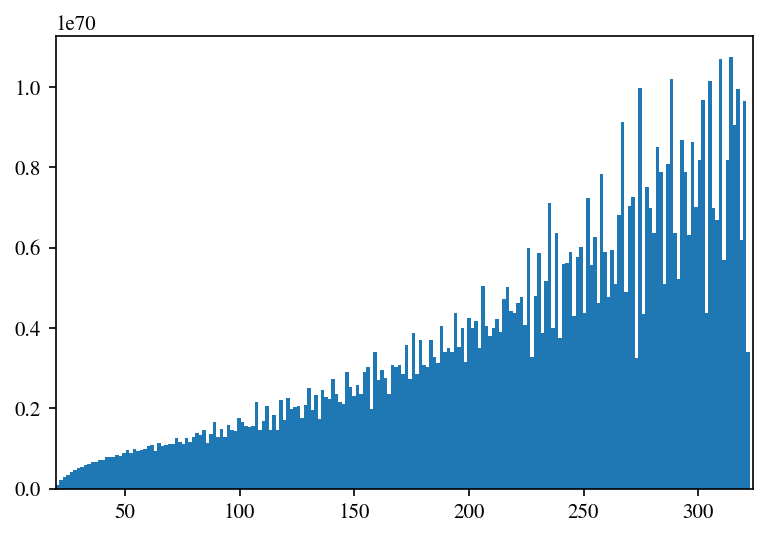

In [43]:
null = plt.hist(sp['entropy'], range=(20,324), weights=sp['cell_volume'], bins=200)
plt.xlim(20, 324)

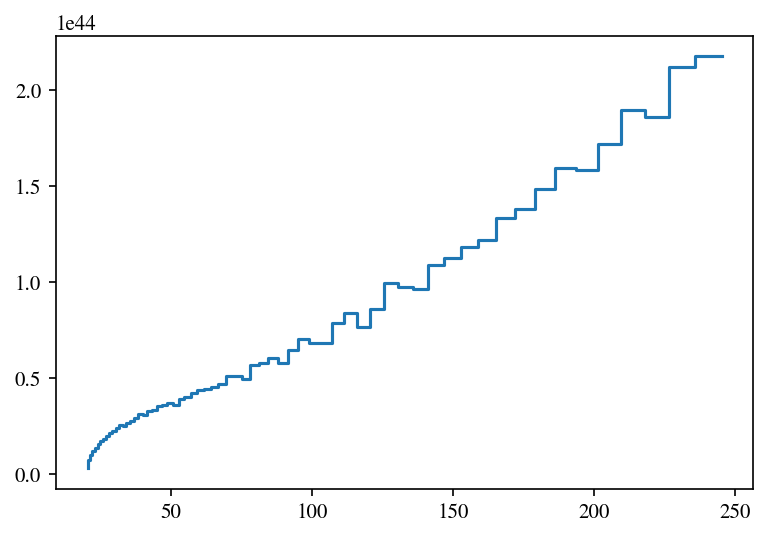

In [20]:
plt.step(prof_entropy.x, prof_entropy['cell_mass'])
#plt.semilogx()

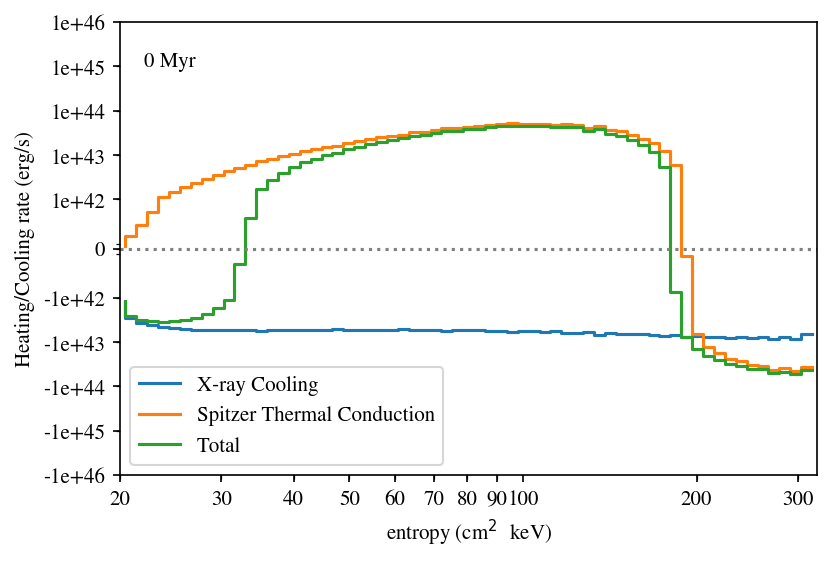

In [23]:
plt.step(prof_entropy.x, -prof_entropy['xray_luminosity_0.1_100_keV'], label='X-ray Cooling')
plt.step(prof_entropy.x, prof_entropy['spitzer_heating_rate'], label='Spitzer Thermal Conduction')
plt.step(prof_entropy.x, prof_entropy['spitzer_heating_rate']-prof_entropy['xray_luminosity_0.1_100_keV'], label='Total')
plt.ylim(-1E46, 1E46)
plt.yscale('symlog', linthreshy=1E42)
yticks = [-1E46, -1E45, -1E44, -1E43, -1E42, 0, 1E42, 1E43, 1E44, 1E45, 1E46]
ytick_labels = 
plt.yticks(yticks, yticks)
plt.ylabel('Heating/Cooling rate (erg/s)')
plt.semilogx()
plt.xlim(20, 324)
entropy_ticks = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300]
plt.xticks(entropy_ticks, entropy_ticks)
plt.xlabel(r'entropy (cm$^2\ $ keV)')
plt.axhline(0, ls=':', color='grey')
plt.text(22, 1E45, '%.0f Myr' % ds.current_time.in_units('Myr'))
plt.legend(loc=4)

In [14]:
extrema = {'entropy': (20, 250), 'spherical_radius': ((10, 'kpc'), (150, 'kpc'))}
fields = ['spitzer_heating_rate', 'xray_luminosity_0.1_100_keV', 'cell_mass']
prof = yt.create_profile(sp, ['spherical_radius', 'entropy'], fields, weight_field=None,
                         extrema=extrema)

/home/ychen/src/yt-git/yt/visualization/plot_container.py:118: RuntimeWarning: invalid value encountered in log10
  expA = np.floor(np.log10(vmin))



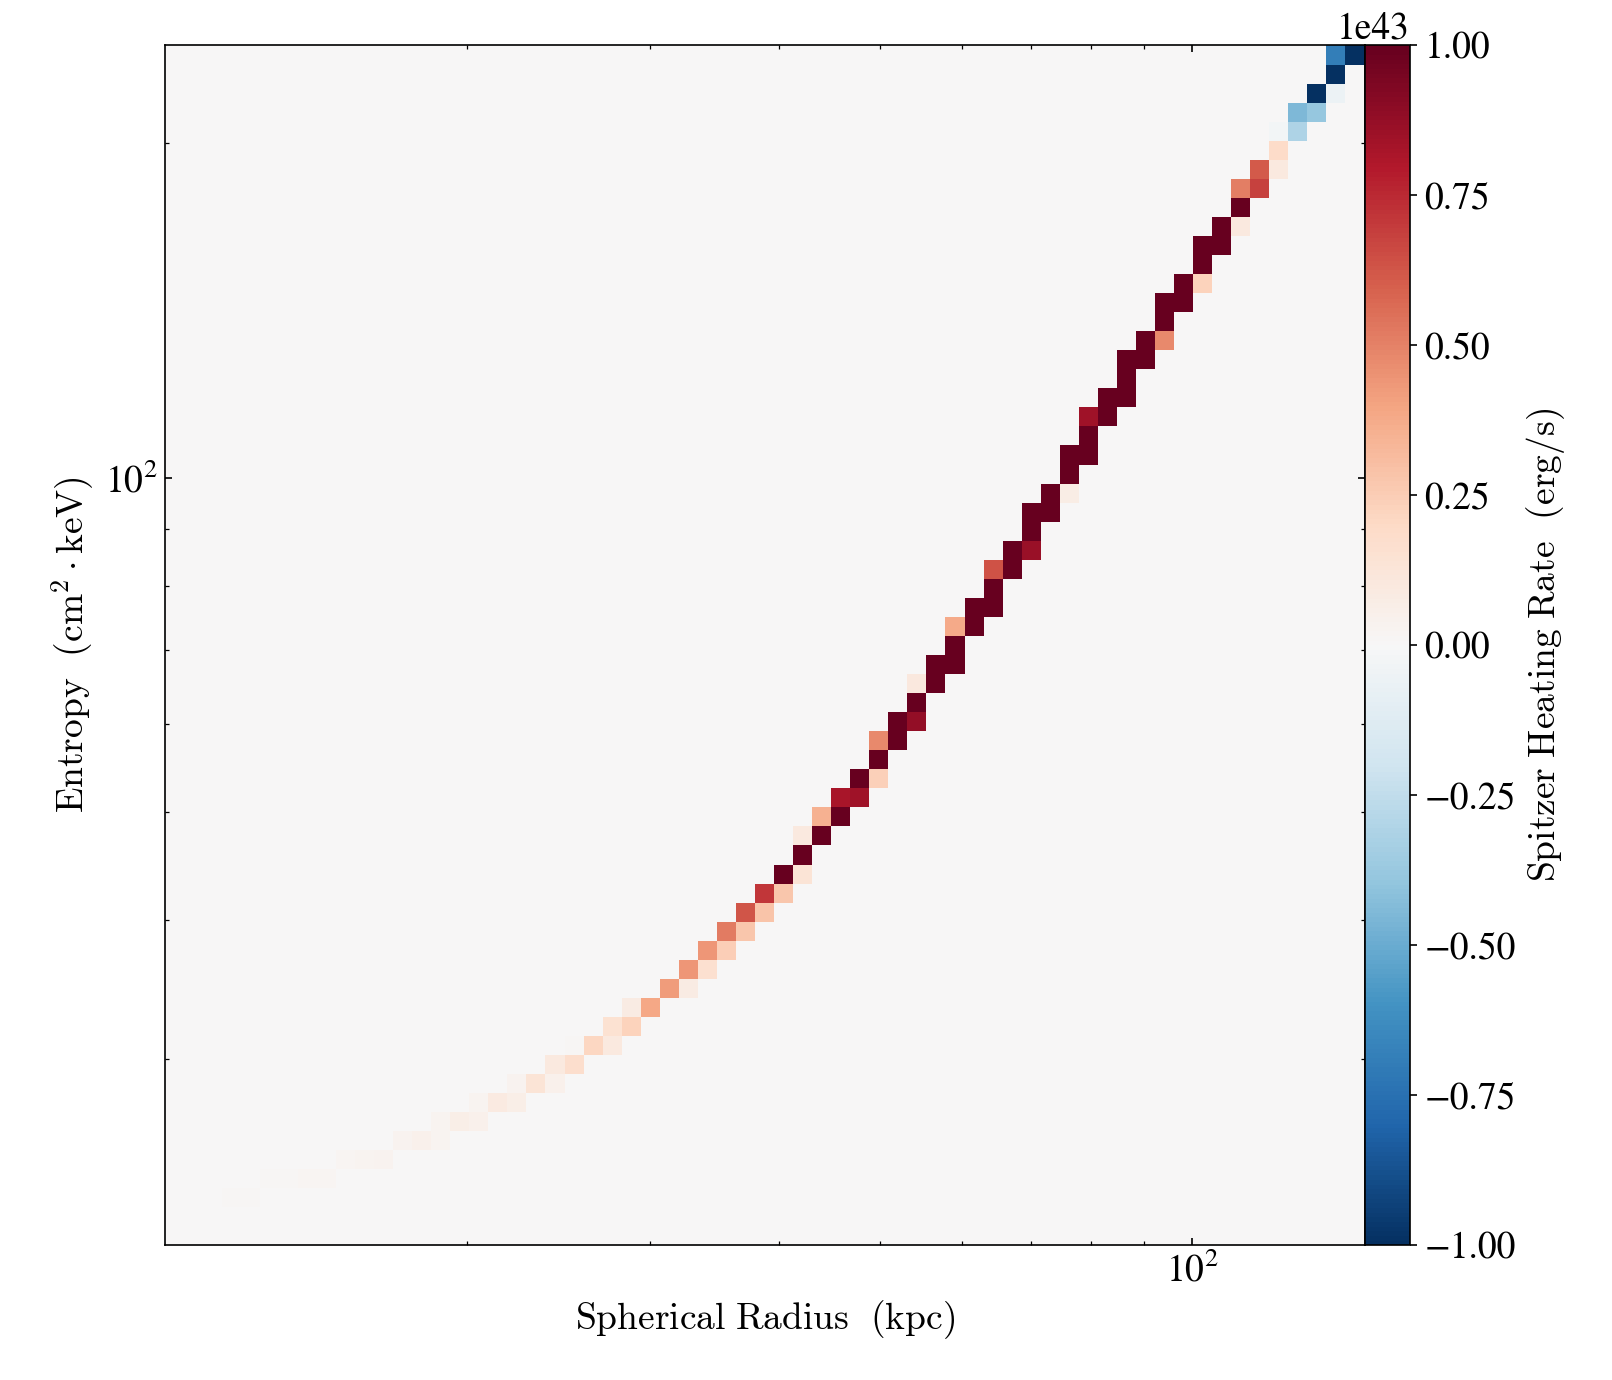
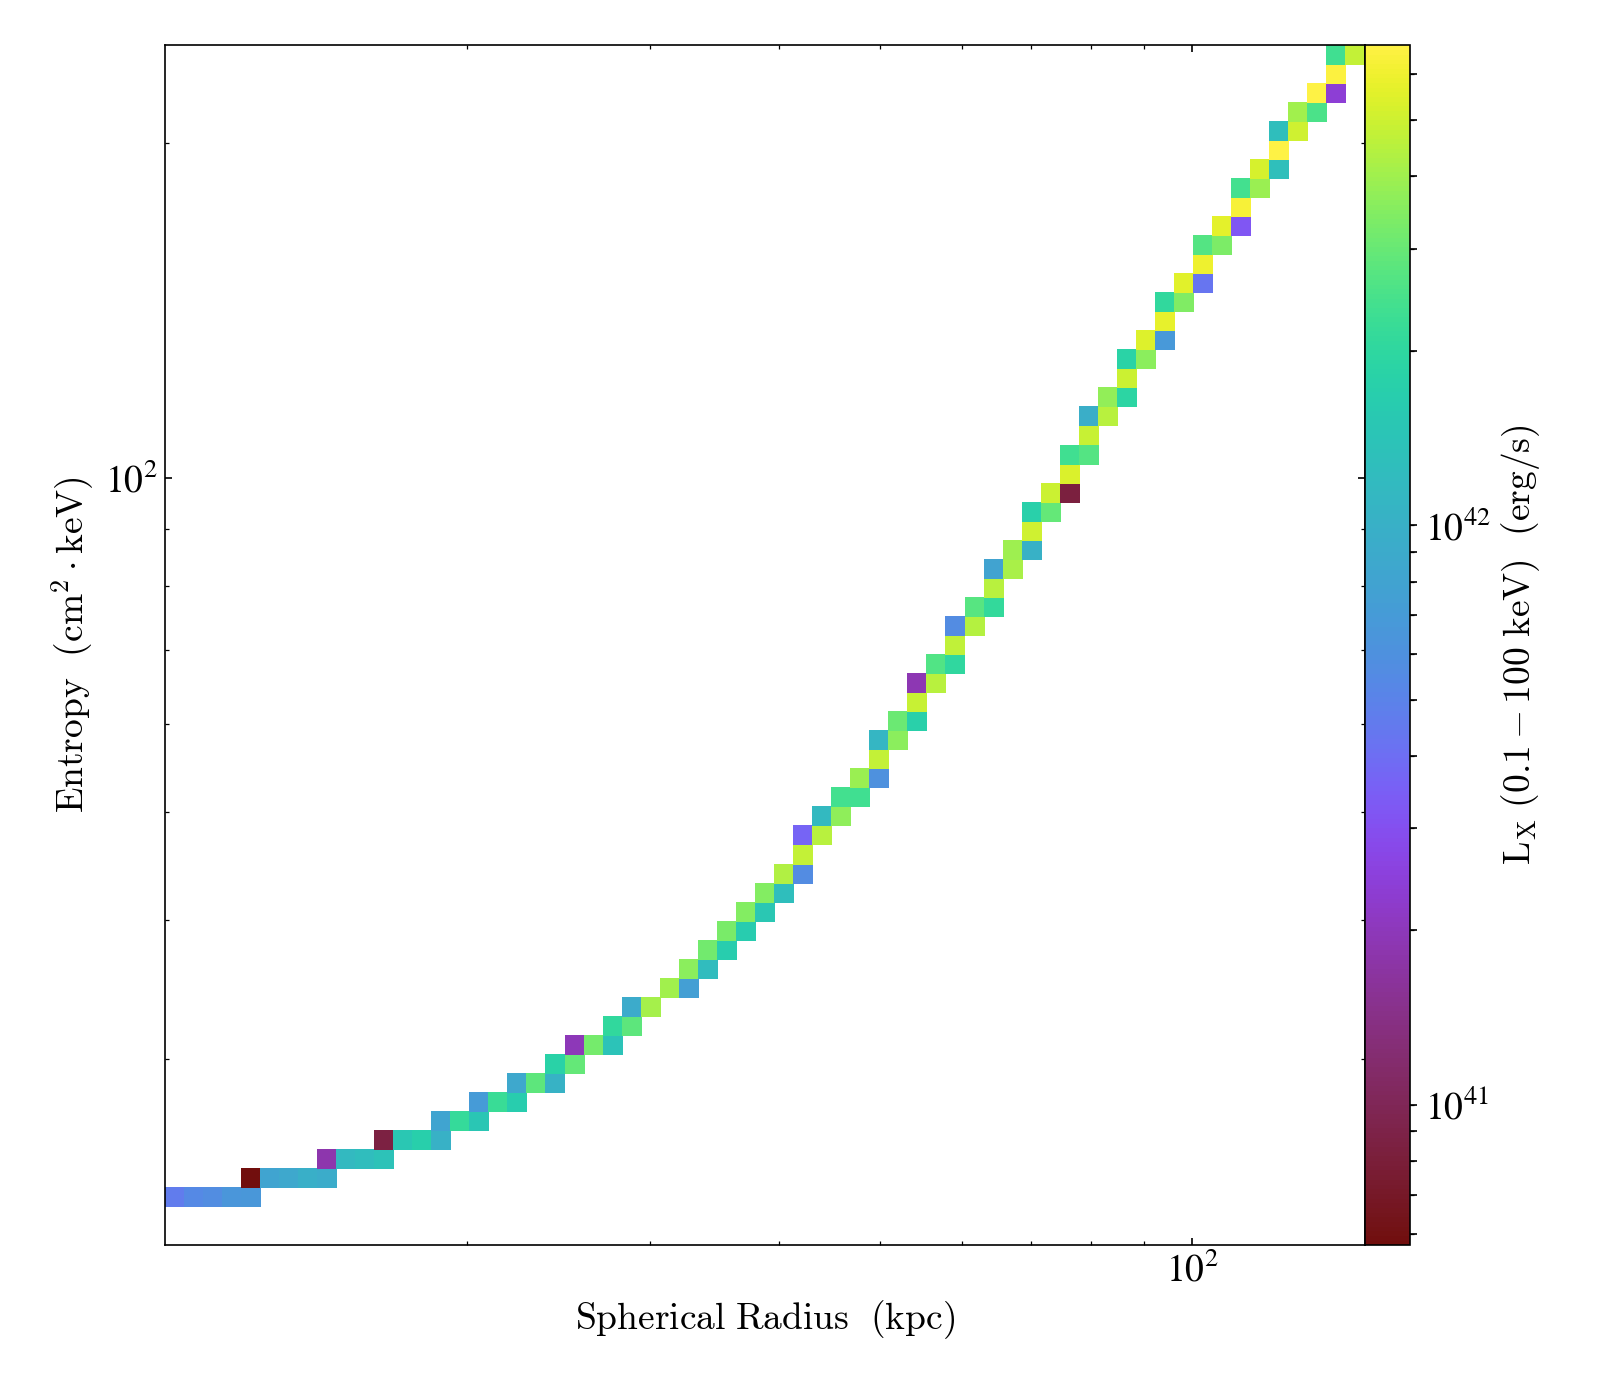
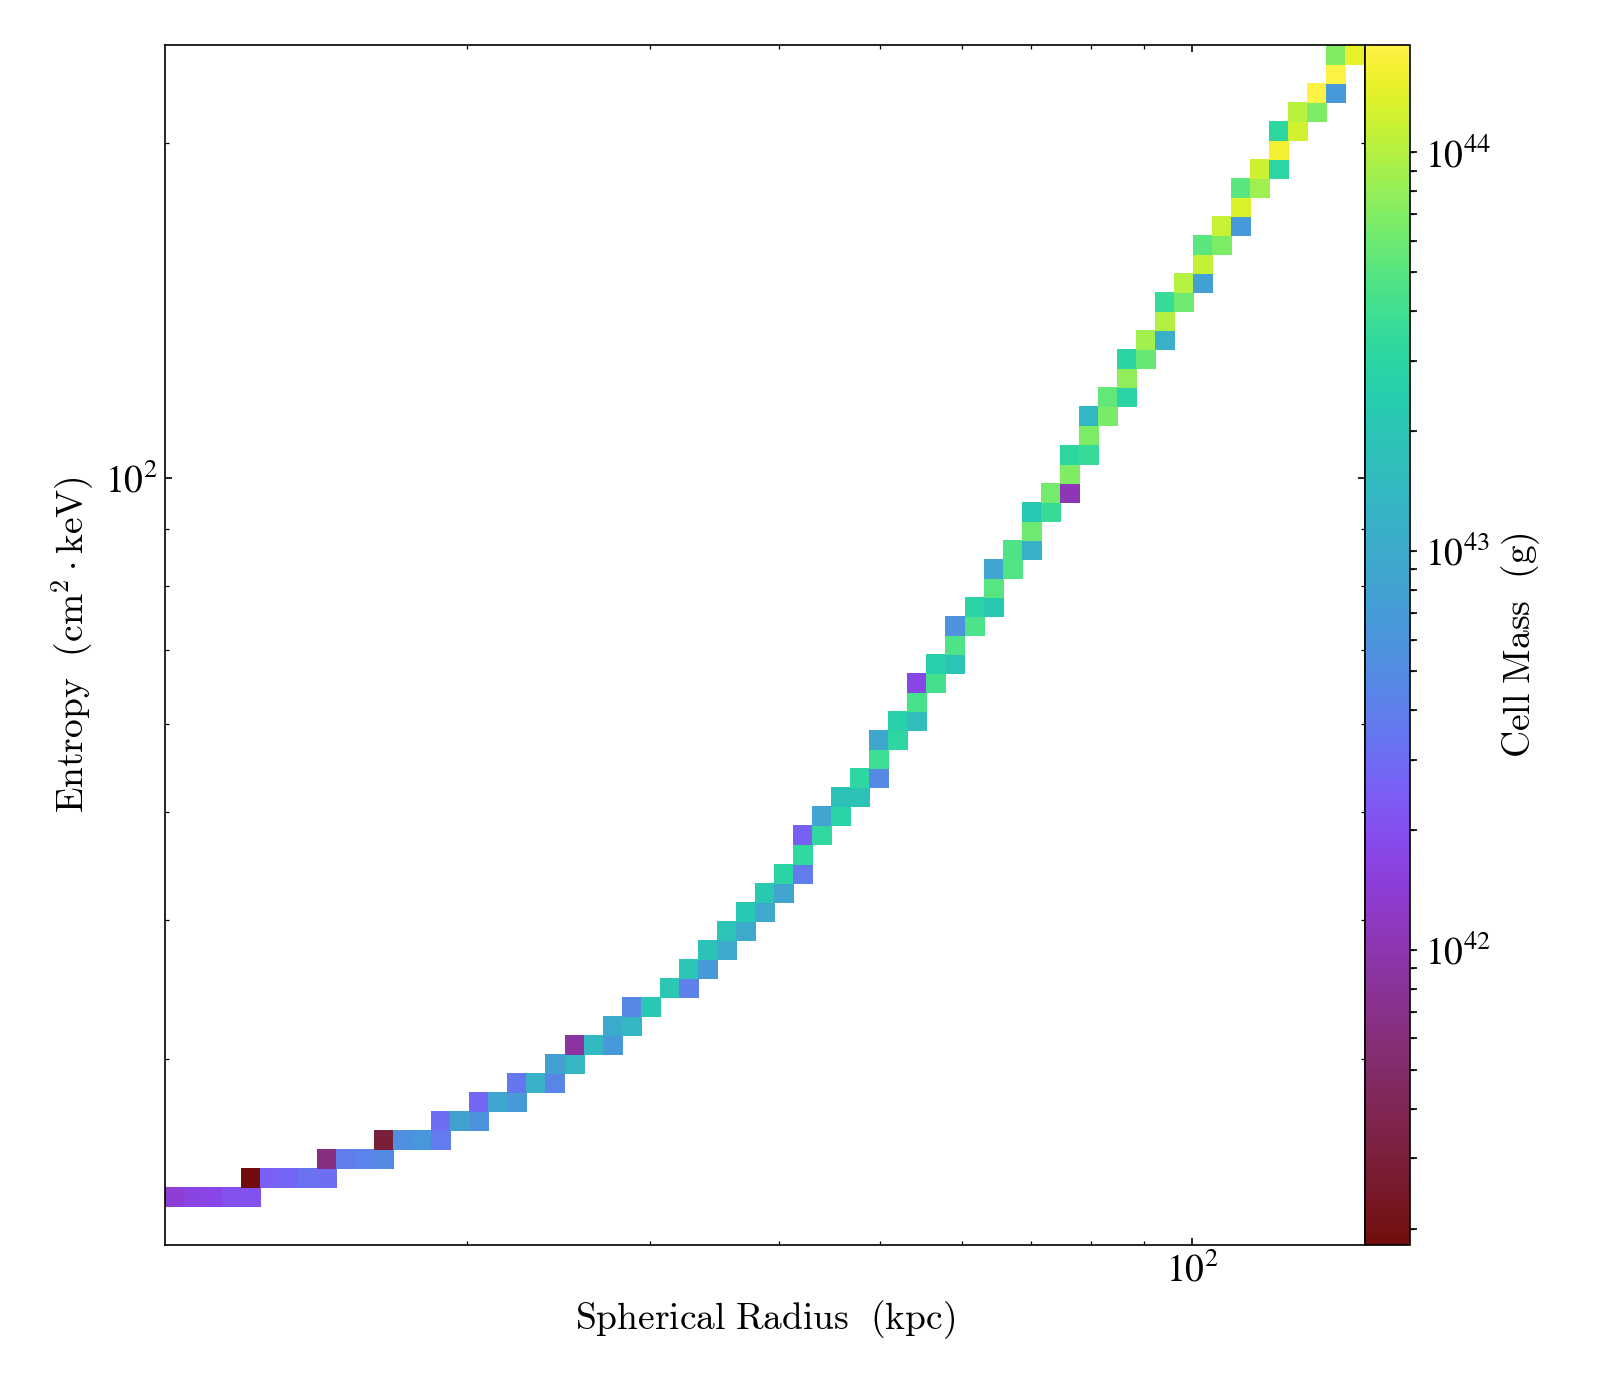

In [40]:
pp = yt.PhasePlot.from_profile(prof)
pp.set_unit('spherical_radius', 'kpc')
pp.set_cmap('spitzer_heating_rate', 'RdBu_r')
pp.set_log('spitzer_heating_rate', False)
pp.set_zlim('spitzer_heating_rate', -1E43, 1E43)

/home/ychen/src/yt-git/yt/visualization/plot_container.py:118: RuntimeWarning: invalid value encountered in log10
  expA = np.floor(np.log10(vmin))


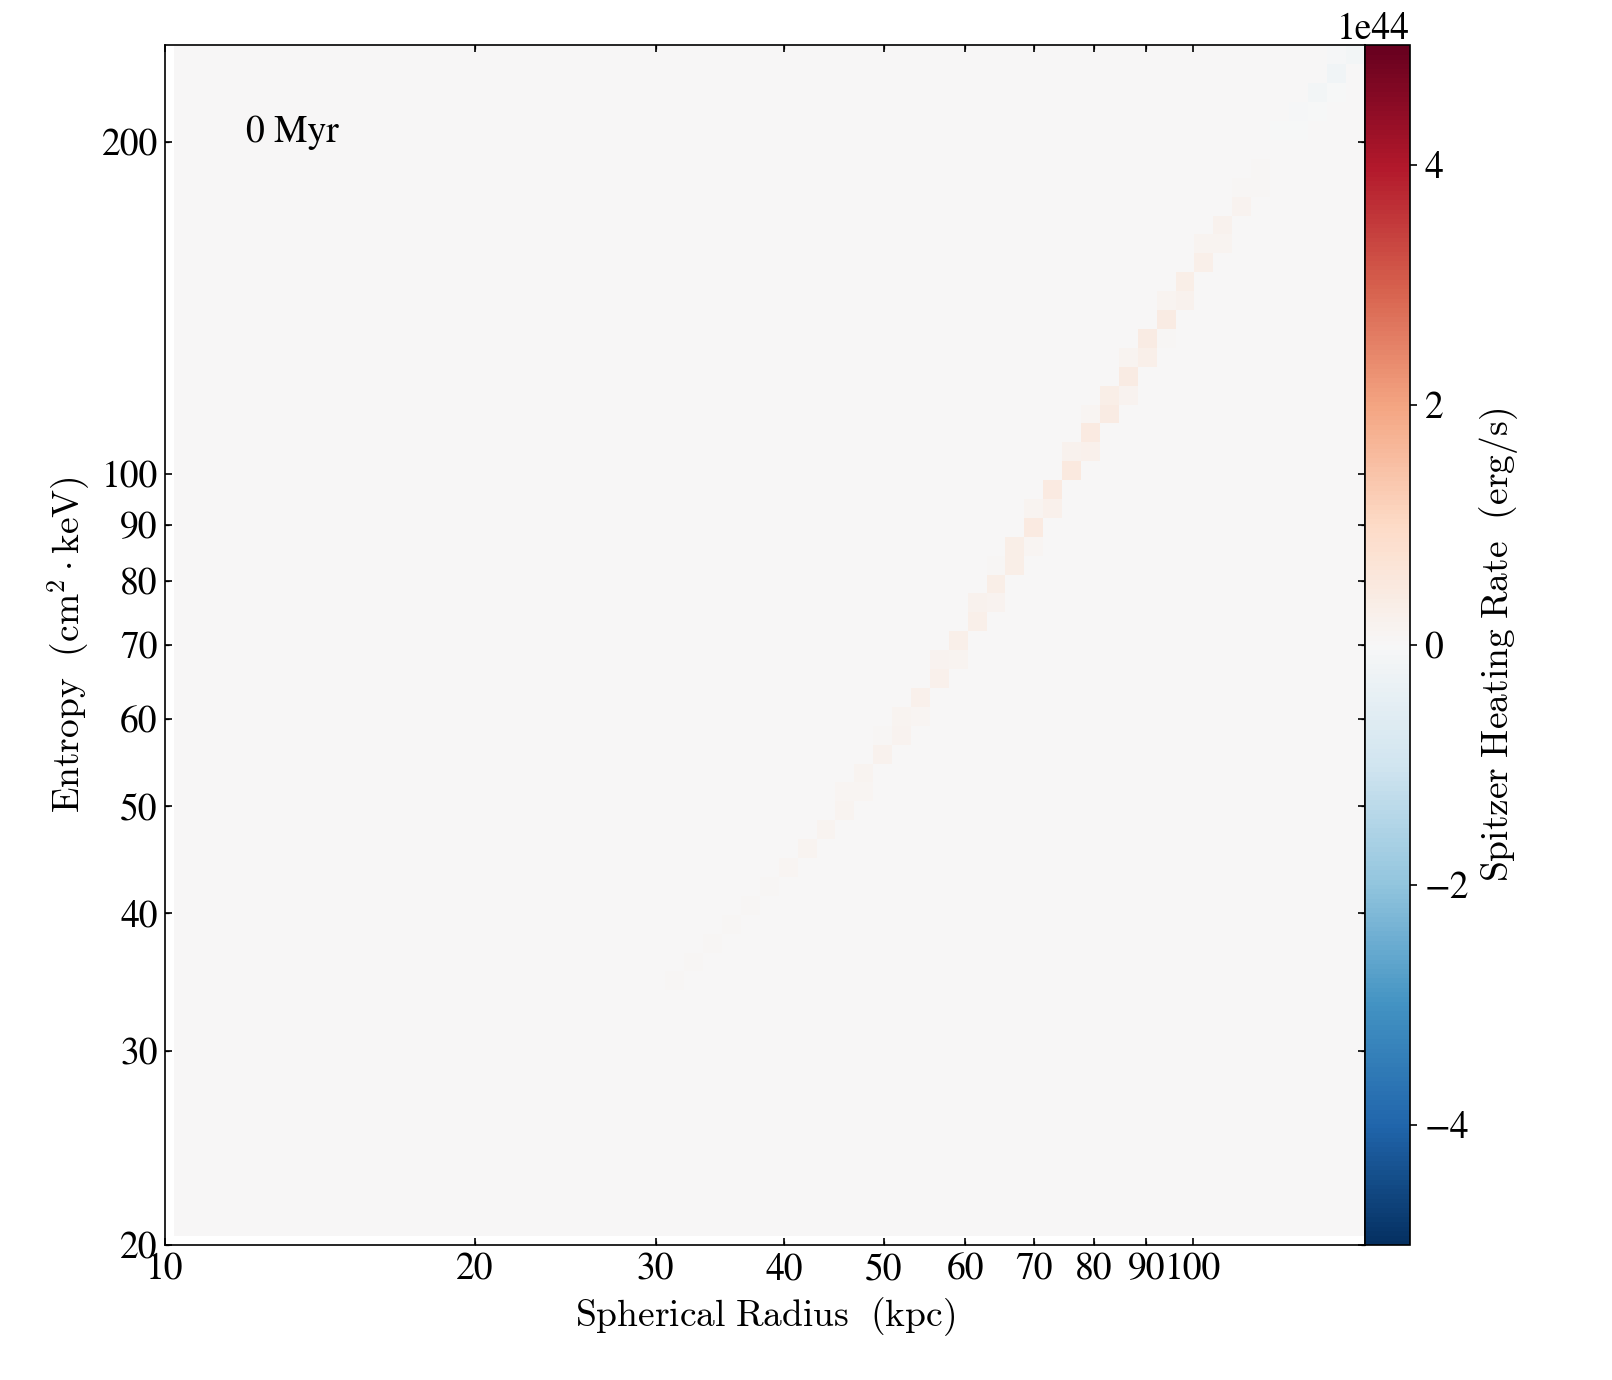

In [13]:
from yt.visualization.plot_container import FieldTransform
from yt.visualization.tick_locators import LogLocator

linthresh = 1E43

symlog_transform = FieldTransform('symlog', None, LogLocator()) 
pp._field_transform['spitzer_heating_rate'] = symlog_transform
pp._field_transform['spitzer_heating_rate'].func = linthresh
pp._setup_plots()
pp.annotate_text(12, 200, '%.0f Myr' % ds.current_time.in_units('Myr'))
print(pp._field_transform['spitzer_heating_rate'])
pp.set_zlim('spitzer_heating_rate', -5E44, 5E44)
plot2 = pp['spitzer_heating_rate']
entropy_ticks = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
plot2.axes.set_yticks(entropy_ticks)
plot2.axes.set_yticklabels(entropy_ticks)
r_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plot2.axes.set_xticks(r_ticks)
plot2.axes.set_xticklabels(r_ticks)
plot2


In [70]:
keV = yt.units.keV
cm = yt.units.cm
kappa = 1*(keV**(5/2)*cm**3)
kappa.convert_to_base()

1.0274860530720377e-22 cm**8*g**(5/2)/s**5

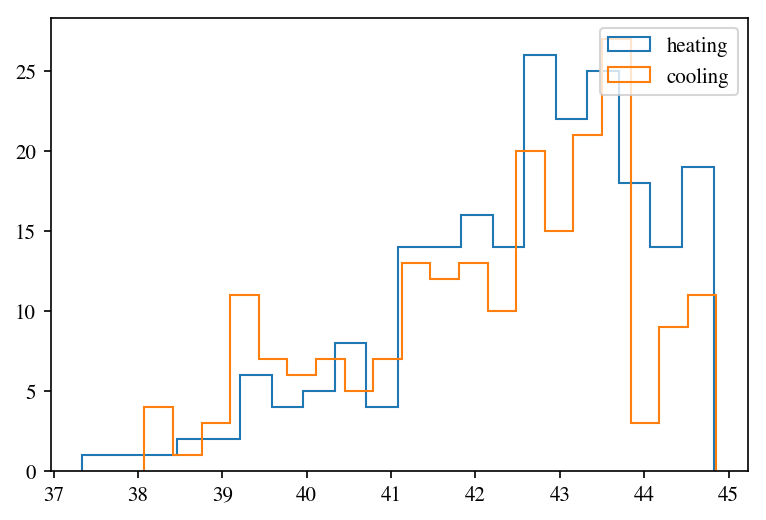

In [35]:
heating_rate = prof['spitzer_heating_rate'].flatten()
null = plt.hist(np.log10(heating_rate[heating_rate>0]), bins=20, histtype='step', label='heating')
null = plt.hist(np.log10(-heating_rate[heating_rate<0]), bins=20, histtype='step', label='cooling')
plt.legend()